In [1]:
#Preamble
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
import copy
import pickle
import emcee
import corner

In [2]:
def generateEllipse(a,b,centerX,centerY, grid, opacity):
    for x in range(len(grid)):
        for y in range(len(grid[0])):
            if a > 0 and b > 0:
                if ((x-centerX)/a)*((x-centerX)/a) + ((y-centerY)/b)*((y-centerY)/b) <= 1:
                    grid[x][y] = opacity
    
    return grid

In [3]:
def transitSim(a,b,r, speed, times, tref, opacity):
    ab = a/b
    br = b/r
    
    tmin = tref - 1/(2*speed)
    tmax = tref + 1/(2*speed)
    transitTimes = [t for t in times if t >= tmin and t <= tmax]
    flux = [1 for t in times if t < tmin]
    differences = []
    for i in range(1,len(transitTimes)):
        differences.append(transitTimes[i] - transitTimes[i-1])
    
    minDiff = np.min(differences)
    intDiffs = [int(d/minDiff) for d in differences]
    length = np.sum(intDiffs)
    
    
    res = int((2*(b+r))/length)
    if res < 1:
        res = 1
    rnew = int(res*length/(2*(1+br)))
    bnew = int(br*rnew)
    anew = int(ab*bnew)
    newIntDiffs = [res*i for i in intDiffs]
    
    starGrid = np.zeros([2*rnew, 4*bnew+2*rnew+4])
    ellipseGrid = np.zeros([2*rnew, 4*bnew+2*rnew+4])
    starGrid = generateEllipse(rnew,rnew,rnew, 2*bnew+rnew, starGrid,1)
    ellipseGrid = generateEllipse(anew,bnew,rnew,3*bnew+2*rnew + 2,ellipseGrid,opacity)
    planetGrid = np.ones([2*rnew,4*bnew+2*rnew+ 4]) - ellipseGrid
    fluxGrid = np.multiply(starGrid,planetGrid)
    initialFlux = np.sum(fluxGrid)
    
    for i in newIntDiffs:
        for j in range(i):
            planetGrid = np.delete(planetGrid,0,1)
            planetGrid = np.append(planetGrid,np.ones([2*rnew,1]),1)
            
        
        fluxGrid = np.multiply(starGrid,planetGrid)
        percentFlux = np.sum(fluxGrid)/initialFlux
        flux.append(percentFlux)
        
    for t in times:
        if t > tmax:
            flux.append(1)
    
    flux.append(1)
    return flux

In [4]:
def logLikelihood(theta, times, flux, fluxErr):
    """
    Calculates the log likelihood based on the difference between the model and the data
    
    Args:
        theta (list) - parameters of the model
        times (list) - time array of the light curve
        flux (list) - array of flux data points
        fluxErr (list) - array of errors for the flux data points
    
    Returns:
        lnl (float) - log likelihood for the given theta values
    """
    xdim, ydim, velocity, tRef, opacity = theta
    fluxPredicted = transitSim(xdim, ydim,20,velocity,times, tRef,opacity)
    error = [((flux[i] - fluxPredicted[i])**2) /(2*fluxErr[i]**2) for i in range(len(flux))]
    lnl = -np.sum(error)
    return lnl

In [5]:
def logPrior(theta, times):
    """
    Returns flat priors, checking that the given theta values are physically possible
    
    Args:
        theta (list) - parameters of the model
        times (list) time array of the light curve
        
    Returns: 
        lnPrior (float) - fixed log prior value if theta values are allowed, -inf if theta values aren't
    """
    xdim, ydim, velocity, tRef, opacity = theta
    lnPrior = 0
    if times[0] < tRef < times[-1]:##Check to see if center of transit is within the bounds of the light curve
        lnPrior += np.log(1/(times[-1]-times[0]))
    else:
        return -np.inf
    if 0 < xdim < 40 and 0 < ydim < 30 and 0 < velocity < 50 and 0 < opacity < 1: ##Check to see if the shape exists but is not larger than the star
        ##Also check to see that it transits in a consistent direction and not extremely fast
        lnPrior +=  2*np.log(1/100) + np.log(1/50) + np.log(1)
    else:
        return -np.inf
    return lnPrior

In [6]:
def logProbability(theta, times, flux, fluxErr):
    """
    Combines the log likelihood and log prior to get log probability
    
    Args:
        theta (list) - parameters of the model
        times (list)
    """
    startTime = time.time()
    lp = logPrior(theta, times)
    if not np.isfinite(lp):
        return -np.inf
    ll = logLikelihood(theta, times, flux, fluxErr)
    endTime = time.time()
    print(endTime - startTime)
    return (lp + ll)

In [7]:
def getData(filename): 
    """
    Reads the necessary data from the elanor pipeline TESS lightcurve pickle files
    
    Args:
        filename (string) - name of the pickle file excluding the .pkl extension
        
    Returns:
        times (list) - list of times of observations in moditied julian day
        flux (list) - list of normalized flux values
        err (list) - list of error for the flux values
    """
    fp = open("./"+filename+".pkl","rb") 
    data = pickle.load(fp)##Unpickles the file
    fp.close()
    
    q = data[11]==0 ##Get the locations of high quality data
    times = data[6][q]##Take only high quality data
    flux = data[9][q]
    maxFlux = np.median(flux)
    flux /= maxFlux ##Normalize flux
    err = np.ones_like(flux)*np.nanstd(np.diff(flux))##Calculate error
    err /= np.sqrt(2)
    return times, flux, err

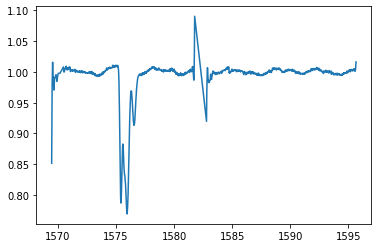

In [8]:
times, flux, _ = getData("lcs/tesslc_400799224")
fig = plt.subplot()
fig.plot(times, flux)
plt.show()

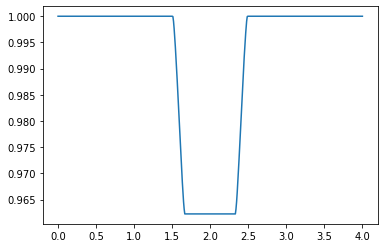

In [13]:
times = np.linspace(0,4,1000)
flux = transitSim(10,10,50,1,times,2,1)
fluxErr = 0.0005*np.ones(1000)
fig = plt.subplot()
fig.plot(times, flux)
plt.show()

In [10]:
pos = [10,10,2,2,1] * np.ones([10,5]) + np.random.random([10,5]) - 0.5
nwalkers, ndim = pos.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logProbability, args = (times, flux, fluxErr))
    sampler.run_mcmc(pos,500, progress = True)

0.024013280868530273
0.0163266658782959
0.030031442642211914
0.03367257118225098
0.017420530319213867
0.04570722579956055


  0%|                                                   | 0/500 [00:00<?, ?it/s]

0.02301478385925293
0.01543426513671875


/home/jbromley/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


0.01875162124633789
0.039223670959472656
0.03963804244995117


  0%|                                           | 1/500 [00:00<01:54,  4.38it/s]

0.08778667449951172
0.02540731430053711
0.04030632972717285
0.03383207321166992
0.020900487899780273
0.04174995422363281


  0%|▏                                          | 2/500 [00:00<01:48,  4.59it/s]

0.04298853874206543
0.025510787963867188


  1%|▎                                          | 3/500 [00:00<01:38,  5.05it/s]

0.035678863525390625
0.01798844337463379
0.023017406463623047
0.01762533187866211
0.04966855049133301
0.04362964630126953
0.05939078330993652
0.01937103271484375
0.03486776351928711
0.06640863418579102
0.016286849975585938


  1%|▎                                          | 4/500 [00:00<01:56,  4.27it/s]

0.04389333724975586
0.021988868713378906
0.10505223274230957
0.07457971572875977


  1%|▍                                          | 5/500 [00:01<02:12,  3.75it/s]

0.0428617000579834
0.056319236755371094
0.018021821975708008
0.15798211097717285
0.01840043067932129
0.041330575942993164
0.024124622344970703
0.02007269859313965
0.056845664978027344


  1%|▌                                          | 6/500 [00:01<03:03,  2.70it/s]

0.1963489055633545
0.05228877067565918
0.07437539100646973


  1%|▌                                          | 7/500 [00:02<03:20,  2.46it/s]

0.24753379821777344
0.016711711883544922
0.06711912155151367
0.011097431182861328
0.012061595916748047
0.04416203498840332
0.011111021041870117
0.07656049728393555
0.2905104160308838
0.019004344940185547
0.020354509353637695
0.08467411994934082
0.021672487258911133


  2%|▋                                          | 8/500 [00:02<03:48,  2.15it/s]

0.061125993728637695
0.022514820098876953
0.04705309867858887


  2%|▊                                          | 9/500 [00:08<16:26,  2.01s/it]

5.189525365829468
0.04897022247314453
0.029221773147583008
0.02096271514892578
0.043549299240112305
0.012272119522094727
0.019659757614135742
0.046712636947631836
0.07524943351745605
0.049405813217163086


  2%|▊                                         | 10/500 [00:08<12:52,  1.58s/it]

0.3357679843902588
0.017379283905029297
0.042174339294433594
0.023688554763793945
0.021386146545410156
0.053709983825683594
0.014458417892456055
0.020208120346069336


  2%|▉                                         | 11/500 [00:09<09:30,  1.17s/it]

0.05159449577331543
0.050664663314819336
0.010038137435913086
0.0464177131652832


  2%|█                                         | 12/500 [00:09<07:42,  1.06it/s]

0.1969904899597168
0.009458541870117188
0.13587617874145508
0.010448217391967773
0.027506589889526367
0.029456377029418945
0.020501375198364258
0.015799283981323242
0.012135744094848633
0.021589040756225586
0.07416749000549316


  3%|█                                         | 13/500 [00:09<06:19,  1.28it/s]

0.18895173072814941
0.022632598876953125
0.007909536361694336
0.05305886268615723
0.03897380828857422
0.0216827392578125
0.028437137603759766


  3%|█▏                                        | 14/500 [00:10<04:56,  1.64it/s]

0.06334590911865234
0.015405416488647461
0.028733015060424805
0.020517349243164062
0.02227044105529785
0.042974233627319336


  3%|█▎                                        | 15/500 [00:10<04:48,  1.68it/s]

0.3032493591308594
0.0991055965423584
0.023562908172607422
0.013616323471069336
0.03302502632141113
0.02373218536376953
0.06830358505249023
0.03784537315368652
0.025310516357421875
0.04521942138671875


  3%|█▎                                        | 16/500 [00:11<05:07,  1.57it/s]

0.3047337532043457
0.13949799537658691
0.030510663986206055
0.040297508239746094
6.193343639373779
0.02534174919128418
0.0652923583984375
0.007938385009765625
0.02446722984313965
0.051824092864990234


  3%|█▍                                        | 17/500 [00:18<19:59,  2.48s/it]

0.3371710777282715
0.03277778625488281
0.03776884078979492
0.03580641746520996
0.12493252754211426
0.019802093505859375
0.007844209671020508
0.04502224922180176
0.02436232566833496
0.08321785926818848


  4%|█▌                                        | 18/500 [00:18<15:00,  1.87s/it]

0.04678821563720703
0.026374101638793945
0.016068696975708008
0.04382658004760742
0.036385536193847656
0.04744839668273926


  4%|█▌                                        | 19/500 [00:20<14:09,  1.77s/it]

1.3167088031768799
0.03411865234375
0.015331268310546875
5.999855041503906
0.026143312454223633
0.04664874076843262
0.026047468185424805
0.06248331069946289
0.03780865669250488

  4%|█▋                                        | 20/500 [00:26<24:49,  3.10s/it]


0.03709125518798828
0.022205114364624023
0.029508590698242188
0.05342912673950195
0.004266500473022461
0.048037052154541016
0.044092416763305664


  4%|█▊                                        | 21/500 [00:28<22:40,  2.84s/it]

1.9063968658447266
0.07819700241088867
0.020123004913330078
0.034806251525878906
0.6333591938018799
0.026241540908813477
0.09832501411437988
0.011046886444091797
0.03791928291320801


  4%|█▊                                        | 22/500 [00:29<18:34,  2.33s/it]

0.25543856620788574
0.02191781997680664
0.02352309226989746
0.0307924747467041
0.26738429069519043
0.05617332458496094
0.03243541717529297
0.011509895324707031
0.011931180953979492


  5%|█▉                                        | 23/500 [00:30<14:15,  1.79s/it]

0.09952211380004883
0.021172046661376953
0.030732393264770508
0.01139974594116211
0.04412651062011719
0.054709434509277344


  5%|██                                        | 24/500 [00:30<11:01,  1.39s/it]

0.1803138256072998
0.04111790657043457
0.05406904220581055
0.01886296272277832
0.03838348388671875
0.1113576889038086
0.07430386543273926
0.028975486755371094


  5%|██                                        | 25/500 [00:31<10:18,  1.30s/it]

0.7366433143615723
0.013547658920288086
0.07244229316711426
0.007307767868041992
0.07020783424377441
0.023729324340820312


  5%|██▏                                       | 26/500 [00:32<07:49,  1.01it/s]

0.028189897537231445
0.048462629318237305
0.022449493408203125
0.04117393493652344
0.014336109161376953
0.02214217185974121
0.03050851821899414
0.10275554656982422
0.026611804962158203
0.04318046569824219
0.12320327758789062


  5%|██▎                                       | 27/500 [00:32<06:22,  1.24it/s]

0.0285642147064209
0.031644344329833984
0.02453899383544922
0.1328732967376709


  6%|██▎                                       | 28/500 [00:32<05:10,  1.52it/s]

0.02072453498840332
0.037641048431396484
0.026660680770874023
0.02643609046936035
0.025883913040161133
0.019029855728149414
0.022231578826904297
0.008324384689331055
0.027603626251220703
0.040671348571777344


  6%|██▍                                       | 29/500 [00:33<05:08,  1.53it/s]

0.4588503837585449
0.04219865798950195
0.026995420455932617
0.07139921188354492
0.014035463333129883
0.05769062042236328
0.04675722122192383
0.008029699325561523
0.02003335952758789
0.03021836280822754


  6%|██▌                                       | 30/500 [00:34<05:06,  1.53it/s]

0.34161925315856934
0.022733449935913086
0.0338435173034668
0.029173612594604492
0.24282145500183105
0.026564598083496094
0.017216205596923828
0.008993148803710938
0.022721290588378906


  6%|██▌                                       | 31/500 [00:34<05:20,  1.46it/s]

0.2805023193359375
0.025905370712280273
0.06122541427612305
0.02076125144958496
0.0380704402923584
0.011781454086303711
0.1046445369720459
0.022425413131713867
0.25786352157592773


  6%|██▋                                       | 32/500 [00:41<19:23,  2.49s/it]

6.2076215744018555
0.025903701782226562
0.020021915435791016
0.05301713943481445
0.02608966827392578
0.038779497146606445
0.025656700134277344


  7%|██▊                                       | 33/500 [00:42<14:41,  1.89s/it]

0.19452881813049316
0.09967947006225586
0.023425817489624023
0.014615774154663086
0.021580219268798828
0.021349191665649414
0.008875846862792969


  7%|██▊                                       | 34/500 [00:42<10:46,  1.39s/it]

0.05818653106689453
0.026398420333862305
0.00973963737487793
0.05370926856994629
0.019440174102783203
0.028453826904296875
0.26298999786376953
0.032605648040771484
0.053597450256347656
0.030353069305419922
0.04906940460205078
0.02523660659790039


  7%|██▉                                       | 35/500 [00:42<08:47,  1.13s/it]

0.03802323341369629
0.02602410316467285
0.4699971675872803


  7%|███                                       | 36/500 [00:43<08:32,  1.11s/it]

0.3433048725128174
0.02848362922668457
0.0524139404296875
0.01337122917175293
0.046985626220703125
0.0318605899810791
0.017804384231567383
0.025637388229370117
0.03248167037963867
0.07306623458862305
0.032096147537231445
0.04490375518798828
0.01081538200378418


  7%|███                                       | 37/500 [00:44<06:48,  1.13it/s]

0.024743080139160156
0.08184123039245605
0.0306704044342041
0.03135395050048828
0.01614236831665039
0.048015594482421875
0.020853519439697266
0.033089637756347656
0.10722041130065918


  8%|███▏                                      | 38/500 [00:44<05:45,  1.34it/s]

0.09888601303100586
0.03874540328979492
0.03720593452453613
0.031102895736694336
0.025778770446777344
0.2291243076324463
0.11243224143981934
0.03268122673034668
0.03562760353088379


  8%|███▎                                      | 39/500 [00:45<05:16,  1.46it/s]

0.029504776000976562
0.03570151329040527
0.02499842643737793


  8%|███▎                                      | 40/500 [00:45<04:31,  1.70it/s]

0.1623365879058838
0.039678096771240234
0.01771378517150879
0.012322664260864258
0.030721187591552734
0.032602548599243164
0.039118289947509766
0.9580166339874268
0.04120588302612305
0.058020591735839844
0.025383710861206055
0.027051687240600586
0.02472543716430664
0.016808271408081055


  8%|███▍                                      | 41/500 [00:46<05:52,  1.30it/s]

0.02984142303466797
0.011888504028320312
0.02599310874938965
0.02405834197998047
0.19136905670166016
0.053579092025756836
0.13231134414672852


  8%|███▌                                      | 42/500 [00:47<05:27,  1.40it/s]

0.09515976905822754
0.018810510635375977
0.027057886123657227
0.02708125114440918
0.16913843154907227
0.022957801818847656
0.029040813446044922
0.0513463020324707
0.01126718521118164
0.03089141845703125
0.022616863250732422


  9%|███▌                                      | 43/500 [00:47<05:03,  1.51it/s]

0.08346843719482422
0.09158062934875488
0.00926065444946289
0.021736860275268555
0.18102669715881348
0.05659174919128418
0.033563852310180664
0.01844644546508789
0.05781197547912598


  9%|███▋                                      | 44/500 [00:48<04:31,  1.68it/s]

0.0553736686706543
0.01832413673400879
0.03050541877746582
0.008473396301269531
0.019421815872192383
0.04278969764709473


  9%|███▊                                      | 45/500 [00:52<13:22,  1.76s/it]

4.250102996826172
0.04389595985412598
0.0674431324005127
0.03228354454040527
0.02954578399658203
0.025414466857910156
0.06401634216308594
0.026964664459228516
0.015232086181640625
0.14212727546691895
0.18623685836791992


  9%|███▊                                      | 46/500 [00:53<10:51,  1.44s/it]

0.030824661254882812
0.11119294166564941
0.028531312942504883
0.022642135620117188
0.26666855812072754
0.08325576782226562
0.027130603790283203
0.018419265747070312
0.022549152374267578
0.04280257225036621


  9%|███▉                                      | 47/500 [00:54<08:58,  1.19s/it]

0.04623556137084961
0.0467534065246582
0.058538198471069336
0.03740429878234863
0.07594823837280273
0.02735280990600586
0.08621907234191895
0.016941070556640625
0.026304960250854492
0.03805947303771973


 10%|████                                      | 48/500 [00:54<07:11,  1.05it/s]

0.035703420639038086
0.12090277671813965
0.04383969306945801
0.3063812255859375
0.0315706729888916
0.03129386901855469
0.026682615280151367
0.01220846176147461


 10%|████                                      | 49/500 [00:55<06:52,  1.09it/s]

0.159592866897583
0.018311262130737305
0.06535601615905762
0.03184151649475098
0.05478549003601074
0.2768256664276123
0.16166162490844727
0.027779817581176758


 10%|████▏                                     | 50/500 [00:56<06:40,  1.12it/s]

0.12694668769836426
0.011794090270996094
0.0379643440246582
0.024302244186401367
0.07475996017456055
0.0321810245513916
0.13941073417663574
0.028790950775146484
0.1382443904876709
0.031420230865478516


 10%|████▎                                     | 51/500 [00:56<06:06,  1.22it/s]

0.08913564682006836
0.02655315399169922
0.034731149673461914
0.11735105514526367
0.023057222366333008
0.07203173637390137
0.04579305648803711
0.0339663028717041
0.044207096099853516


 10%|████▎                                     | 52/500 [00:57<05:16,  1.42it/s]

0.046469688415527344
0.06212472915649414
0.0752568244934082
0.03672194480895996
0.07230377197265625
0.02723217010498047
0.14641356468200684
0.023148775100708008
0.03699231147766113
0.04653573036193848
0.03829669952392578
0.44378113746643066
0.038724660873413086


 11%|████▍                                     | 53/500 [00:58<06:07,  1.21it/s]

0.21755313873291016
0.019244670867919922
0.05708432197570801
0.03263592720031738
0.13161873817443848
0.04254937171936035
0.04512810707092285
0.04046010971069336
0.014337301254272461


 11%|████▌                                     | 54/500 [00:58<05:32,  1.34it/s]

0.1749410629272461
0.023253917694091797
0.01621866226196289
0.04003643989562988
0.39600491523742676
0.032544612884521484
0.013158798217773438
0.1329209804534912
0.013633489608764648


 11%|████▌                                     | 55/500 [00:59<05:39,  1.31it/s]

0.13286709785461426
0.022342920303344727
0.03764152526855469
0.13149595260620117


 11%|████▋                                     | 56/500 [01:00<04:54,  1.51it/s]

0.0751340389251709
0.02703261375427246
0.02770209312438965
0.0769195556640625
0.02142024040222168
0.048340559005737305
0.05730080604553223
0.028632164001464844
0.020738840103149414
0.3181471824645996
0.9534523487091064
0.04245901107788086
0.04133033752441406


 11%|████▊                                     | 57/500 [01:01<07:29,  1.01s/it]

0.32092928886413574
0.07443737983703613
0.034093379974365234
0.17037749290466309
0.03565788269042969
0.03872990608215332
0.04088759422302246
0.04045915603637695
0.04036259651184082


 12%|████▊                                     | 58/500 [01:02<06:44,  1.09it/s]

0.19836902618408203
0.045952558517456055
0.037766456604003906
0.1267836093902588
0.06721711158752441
0.592315673828125
0.03263235092163086


 12%|████▉                                     | 59/500 [01:04<08:10,  1.11s/it]

0.5930695533752441
0.043524980545043945
0.030682086944580078
0.01659679412841797
0.07157659530639648
0.13961195945739746
0.027446269989013672
0.03644680976867676
0.25278496742248535
0.22201108932495117
0.03440546989440918
0.0907449722290039


 12%|█████                                     | 60/500 [01:05<08:00,  1.09s/it]

0.1436939239501953
0.03834104537963867
0.11760973930358887
0.07080459594726562
0.12810969352722168
0.030472278594970703
0.022011280059814453
0.3740684986114502
0.02620697021484375


 12%|█████                                     | 61/500 [01:06<07:52,  1.08s/it]

0.23054885864257812
0.06478738784790039
0.10177183151245117
0.04056525230407715
0.12080502510070801


 12%|█████▏                                    | 62/500 [01:07<07:00,  1.04it/s]

0.15638947486877441
0.04390573501586914
0.09064340591430664
0.019606351852416992
0.040117740631103516
0.028246641159057617
0.022107839584350586
0.2005748748779297
0.03884387016296387
0.06225252151489258
0.06666231155395508
0.21202826499938965
0.12871551513671875


 13%|█████▎                                    | 63/500 [01:07<06:58,  1.04it/s]

0.18867731094360352
0.20426392555236816
0.03737235069274902
0.06663179397583008
0.12924575805664062
0.18491148948669434
0.05328249931335449
0.08853745460510254
0.03520059585571289
0.8124680519104004


 13%|█████▍                                    | 64/500 [01:09<08:52,  1.22s/it]

0.22047138214111328
0.05434083938598633
0.1140904426574707
0.038815975189208984
2.398616075515747
0.46764540672302246
0.056498050689697266
0.032976388931274414


 13%|█████▍                                    | 65/500 [01:13<13:41,  1.89s/it]

0.2175309658050537
0.05695939064025879
0.09845399856567383
0.052861928939819336
0.11061406135559082
0.09795928001403809
0.14284539222717285
0.20677757263183594
0.029749393463134766
0.508324146270752
0.07831025123596191


 13%|█████▌                                    | 66/500 [01:14<12:48,  1.77s/it]

0.1614220142364502
0.0561223030090332
0.08812880516052246
0.018008947372436523
0.10771417617797852
0.17246007919311523
0.16361451148986816
0.3222615718841553
0.07643246650695801


 13%|█████▋                                    | 67/500 [01:15<11:37,  1.61s/it]

0.22943639755249023
0.03823232650756836
0.09634280204772949
0.014359474182128906
0.17202401161193848
0.1906297206878662
0.223222017288208


 14%|█████▋                                    | 68/500 [01:17<10:57,  1.52s/it]

0.3764913082122803
0.07284927368164062
0.1233062744140625
0.09279751777648926
0.20770645141601562
0.021614789962768555
0.04618954658508301
0.05649995803833008
0.1621537208557129
0.13605499267578125
0.1889801025390625


 14%|█████▊                                    | 69/500 [01:18<10:26,  1.45s/it]

0.3768777847290039
0.08860325813293457
0.1677417755126953
0.08399081230163574
0.7565295696258545
0.14820551872253418
0.04848194122314453
0.5539729595184326
0.041092872619628906


 14%|█████▉                                    | 70/500 [01:21<12:55,  1.80s/it]

0.5978822708129883
0.1256718635559082
0.08083057403564453
0.07574725151062012
0.23743367195129395
0.10578179359436035
0.4217414855957031
0.03229498863220215
0.11257028579711914


 14%|█████▉                                    | 71/500 [01:22<11:58,  1.68s/it]

0.1124563217163086
0.19123220443725586
0.08117079734802246
0.38939404487609863
0.06987929344177246
2.06540846824646
0.17262005805969238
0.11480569839477539
0.06540441513061523


 14%|██████                                    | 72/500 [01:25<15:19,  2.15s/it]

0.15636515617370605
0.12708783149719238
0.0651395320892334
0.7146642208099365
0.16225337982177734
0.08296799659729004
0.1105954647064209
0.07559370994567871
0.11408829689025879
0.19248557090759277


 15%|██████▏                                   | 73/500 [01:27<14:29,  2.04s/it]

0.07125163078308105
0.18253660202026367
0.25814008712768555
0.06949543952941895
0.6761984825134277
0.11172246932983398
0.1989288330078125
0.07633614540100098
0.09856653213500977
0.27999258041381836
0.08914327621459961


 15%|██████▏                                   | 74/500 [01:29<14:32,  2.05s/it]

0.20950055122375488
0.2542002201080322
0.05098891258239746
0.7693626880645752
0.30057287216186523
0.17709708213806152
0.07764482498168945
0.05797767639160156


 15%|██████▎                                   | 75/500 [01:32<16:36,  2.35s/it]

1.1654462814331055
0.1288466453552246
0.05043387413024902
0.09111475944519043
0.21400761604309082
0.02492046356201172
0.1288890838623047
0.3550839424133301
0.06387495994567871
0.6672878265380859
0.27181172370910645
0.07650423049926758


 15%|██████▍                                   | 76/500 [01:34<15:56,  2.26s/it]

0.14554309844970703
0.10176587104797363
0.41987013816833496
0.16638612747192383
0.12889575958251953
0.14514994621276855
0.07783031463623047
0.143049955368042
0.5085437297821045


 15%|██████▍                                   | 77/500 [01:36<15:09,  2.15s/it]

0.2033846378326416
0.1036844253540039
0.1051473617553711
0.13518238067626953
0.18540358543395996
0.1443021297454834
0.08813309669494629
0.2985868453979492
0.16339397430419922


 16%|██████▌                                   | 78/500 [01:38<13:42,  1.95s/it]

0.25201940536499023
0.8026959896087646
0.14961552619934082
0.14755964279174805
0.25331687927246094
0.16735005378723145
0.0903472900390625
0.06628632545471191
0.27690696716308594
0.10066008567810059


 16%|██████▋                                   | 79/500 [01:40<14:10,  2.02s/it]

0.12614035606384277
0.06960654258728027
0.25562453269958496
0.040515899658203125
0.16559290885925293
0.3094666004180908
0.07025504112243652
0.7245297431945801
0.1499652862548828


 16%|██████▋                                   | 80/500 [01:42<14:11,  2.03s/it]

0.11812448501586914
0.13646984100341797
0.07907772064208984
0.14397168159484863
0.24327659606933594
0.12613940238952637
0.14147090911865234
0.07840752601623535
0.18669414520263672


 16%|██████▊                                   | 81/500 [01:43<12:45,  1.83s/it]

0.23203277587890625
0.1189723014831543
0.08968520164489746
0.7097768783569336
0.2553372383117676
0.10505986213684082
0.18795228004455566
0.1128091812133789
0.3257408142089844
0.03586602210998535
0.13335824012756348


 16%|██████▉                                   | 82/500 [01:45<13:28,  1.93s/it]

0.22032475471496582
0.3048224449157715
0.10528302192687988
0.11488795280456543
0.13158965110778809
0.18282747268676758
0.058510541915893555
0.10606694221496582
0.1704416275024414


 17%|██████▉                                   | 83/500 [01:47<12:34,  1.81s/it]

0.340254545211792
0.18239450454711914
0.3372828960418701
0.09180903434753418
0.5918574333190918
0.14395666122436523
0.05959582328796387
0.22658824920654297
0.10513854026794434


 17%|███████                                   | 84/500 [01:49<13:15,  1.91s/it]

0.2740774154663086
0.13496971130371094
0.2709221839904785
0.09832072257995605
0.33074140548706055
0.0871119499206543
0.325941801071167
0.1404738426208496
0.09543943405151367
0.1298995018005371


 17%|███████▏                                  | 85/500 [01:51<12:35,  1.82s/it]

0.1154627799987793
0.11351895332336426
0.12862253189086914
0.13806962966918945
0.27571702003479004
0.21369695663452148
0.209977388381958
0.0300750732421875
0.15663599967956543


 17%|███████▏                                  | 86/500 [01:52<11:31,  1.67s/it]

0.0475919246673584
0.24544358253479004
0.2689054012298584
0.059515953063964844
0.74395751953125
0.11432576179504395
0.051522254943847656
0.1663515567779541
0.10958218574523926


 17%|███████▎                                  | 87/500 [01:54<11:54,  1.73s/it]

0.10171127319335938
0.09471344947814941
0.6093463897705078
0.1776142120361328
0.11860299110412598
0.23052144050598145
0.10440611839294434
0.17035460472106934


 18%|███████▍                                  | 88/500 [01:56<12:04,  1.76s/it]

0.23207974433898926
0.08455801010131836
0.35700178146362305
0.8435890674591064
0.6218609809875488
0.15990924835205078
0.508044958114624
0.11287736892700195
0.10450911521911621
0.12475442886352539


 18%|███████▍                                  | 89/500 [01:59<14:49,  2.16s/it]

0.11693620681762695
0.15562987327575684
0.12718653678894043
0.12648820877075195
0.2448744773864746
0.1677231788635254
0.32018041610717773
0.273653507232666
0.09495353698730469


 18%|███████▌                                  | 90/500 [02:01<13:48,  2.02s/it]

0.16805195808410645
0.15433454513549805
0.27701663970947266
0.24327659606933594
0.10122394561767578
0.30753207206726074
0.20398640632629395
0.12623953819274902
0.1397552490234375
0.16776776313781738


 18%|███████▋                                  | 91/500 [02:02<13:19,  1.96s/it]

0.2296607494354248
0.081024169921875
0.09004878997802734
0.14871788024902344
0.12464523315429688
0.34855008125305176
0.09212398529052734
0.271730899810791
0.14609575271606445


 18%|███████▋                                  | 92/500 [02:04<12:22,  1.82s/it]

0.19154953956604004
0.24097418785095215
0.09084248542785645
0.18004941940307617
0.13727688789367676
0.41057825088500977
0.5161268711090088
0.1251983642578125
0.6031630039215088
0.14102745056152344


 19%|███████▊                                  | 93/500 [02:06<14:00,  2.07s/it]

0.1888566017150879
0.1842513084411621
0.2171459197998047
0.4478437900543213
0.144303560256958
0.2927706241607666
0.08345913887023926
0.10370588302612305
0.2829596996307373
0.14074158668518066


 19%|███████▉                                  | 94/500 [02:09<14:00,  2.07s/it]

0.1774585247039795
0.2794375419616699
0.24216723442077637
0.12222814559936523
0.15160822868347168
0.2307581901550293
0.11379313468933105
0.6988315582275391
0.13930487632751465


 19%|███████▉                                  | 95/500 [02:11<14:23,  2.13s/it]

0.14264249801635742
0.151198148727417
0.1798694133758545
0.1425924301147461
0.1575615406036377
0.3592689037322998
0.13704752922058105
0.19517850875854492
0.12921881675720215
0.11851286888122559


 19%|████████                                  | 96/500 [02:13<14:06,  2.09s/it]

0.39145398139953613
0.18915176391601562
0.06746077537536621
0.15761661529541016
0.17701172828674316
0.060201168060302734
0.4695289134979248
0.14978837966918945
0.12019944190979004
0.20877408981323242


 19%|████████▏                                 | 97/500 [02:15<13:43,  2.04s/it]

0.3425712585449219
0.1673600673675537
0.11339044570922852
0.23204970359802246
0.41664671897888184
0.14300894737243652
0.17195653915405273
0.19929289817810059
0.10742616653442383
0.1881706714630127
0.18193697929382324


 20%|████████▏                                 | 98/500 [02:17<13:35,  2.03s/it]

0.22984099388122559
0.11801791191101074
0.3034813404083252
0.12572336196899414
0.18723416328430176
0.1474928855895996
0.22085857391357422
0.48192667961120605
0.16329121589660645


 20%|████████▎                                 | 99/500 [02:19<13:57,  2.09s/it]

0.3288915157318115
0.14792132377624512
0.18604278564453125
0.06865048408508301
0.16385269165039062
0.17986822128295898
0.22383427619934082
0.2187514305114746
0.1009516716003418


 20%|████████▏                                | 100/500 [02:20<12:29,  1.87s/it]

0.11226654052734375
0.10787534713745117
0.2627081871032715
0.09735369682312012
0.281491756439209
0.1623685359954834
0.16134381294250488
0.08123946189880371
0.1647026538848877
0.17795109748840332


 20%|████████▎                                | 101/500 [02:22<11:53,  1.79s/it]

0.19040918350219727
0.29219651222229004
0.24503397941589355
0.09779906272888184
0.1669766902923584
0.16072654724121094
0.12514328956604004
0.1543262004852295


 20%|████████▎                                | 102/500 [02:24<11:27,  1.73s/it]

0.19095516204833984
0.14931583404541016
0.25740933418273926
0.12035751342773438
0.0844576358795166
0.18268227577209473
0.08413863182067871
0.21454811096191406
0.12530851364135742


 21%|████████▍                                | 103/500 [02:25<10:44,  1.62s/it]

0.15661883354187012
0.14738750457763672
0.14658904075622559
0.1326904296875
0.17477798461914062
0.2048487663269043
0.2929954528808594
0.2046189308166504
0.1838212013244629
0.13557839393615723


 21%|████████▌                                | 104/500 [02:27<10:55,  1.66s/it]

0.25096893310546875
0.09807848930358887
0.3311789035797119
0.16547226905822754
0.14789676666259766
0.2457265853881836
0.09980463981628418
0.19170808792114258
0.13875842094421387


 21%|████████▌                                | 105/500 [02:28<10:49,  1.64s/it]

0.19211506843566895
0.11567163467407227
0.1654517650604248
0.07392096519470215
0.16496634483337402
0.24545526504516602
0.10873103141784668
0.46916985511779785
0.15757107734680176


 21%|████████▋                                | 106/500 [02:30<10:52,  1.66s/it]

0.1762247085571289
0.194899320602417
0.17153191566467285
0.19249272346496582
0.23199176788330078
0.18678712844848633
0.14790058135986328
0.1430213451385498
0.693436861038208
0.1181645393371582


 21%|████████▊                                | 107/500 [02:32<12:09,  1.86s/it]

0.23603081703186035
0.14445710182189941
0.29662585258483887
0.19266486167907715
0.2564249038696289
0.20929241180419922
0.15169525146484375
0.14193248748779297
0.12622809410095215


 22%|████████▊                                | 108/500 [02:34<11:40,  1.79s/it]

0.1018974781036377
0.14269447326660156
0.1665937900543213
0.09003424644470215
0.19555401802062988
0.23727631568908691
0.1979386806488037
0.1335773468017578


 22%|████████▉                                | 109/500 [02:35<11:15,  1.73s/it]

0.2226705551147461
0.19873666763305664
0.16252613067626953
0.1115562915802002
0.32820582389831543
0.1972494125366211
0.20746970176696777
0.15866470336914062
0.1307671070098877
0.2224562168121338


 22%|█████████                                | 110/500 [02:37<11:24,  1.75s/it]

0.28590941429138184
0.17847490310668945
0.11710357666015625
0.2235713005065918
0.36034345626831055
0.20724701881408691
0.16930794715881348
0.1670069694519043


 22%|█████████                                | 111/500 [02:39<11:25,  1.76s/it]

0.2382066249847412
0.11503767967224121
0.31977152824401855
0.1560502052307129
0.19622349739074707
0.300445556640625
0.2040090560913086
0.1437842845916748
0.08863282203674316
0.21198415756225586


 22%|█████████▏                               | 112/500 [02:41<11:39,  1.80s/it]

0.2731025218963623
0.16667962074279785
0.15037965774536133
0.18345403671264648
0.6863374710083008
0.12106156349182129
0.2917461395263672
0.18749761581420898
0.134263277053833
0.43422365188598633


 23%|█████████▎                               | 113/500 [02:44<13:07,  2.04s/it]

0.21344661712646484
0.2012319564819336
0.15902137756347656
0.6482863426208496
0.1514737606048584
0.21753525733947754
0.1598954200744629
0.18874144554138184
0.21367835998535156
0.19265198707580566


 23%|█████████▎                               | 114/500 [02:46<14:08,  2.20s/it]

0.4360313415527344
0.32862019538879395
0.1614069938659668
0.2051069736480713
0.2529306411743164
0.26985764503479004
0.17304611206054688
0.6931757926940918
0.14368963241577148
0.23261213302612305


 23%|█████████▍                               | 115/500 [02:49<15:02,  2.34s/it]

0.218400239944458
0.2026987075805664
0.1789112091064453
0.17867136001586914
0.22854876518249512
0.17199206352233887
0.14163780212402344
0.33262205123901367
0.2916386127471924


 23%|█████████▌                               | 116/500 [02:51<14:13,  2.22s/it]

0.20796489715576172
0.1805250644683838
0.26636672019958496
0.4166891574859619
0.20915508270263672
0.18876242637634277
0.18236804008483887
0.07773852348327637
0.16181111335754395


 23%|█████████▌                               | 117/500 [02:53<13:33,  2.13s/it]

0.20685744285583496
0.14460349082946777
0.16689324378967285
0.17802023887634277
0.6433422565460205
0.243880033493042
0.1849825382232666
0.16897320747375488
0.2852461338043213
0.26810741424560547


 24%|█████████▋                               | 118/500 [02:55<14:14,  2.24s/it]

0.20827293395996094
0.20803427696228027
0.17659616470336914
0.5191981792449951
0.2419123649597168
0.14716482162475586
0.16406035423278809
0.13634824752807617


 24%|█████████▊                               | 119/500 [02:57<13:56,  2.19s/it]

0.3012816905975342
0.193681001663208
0.20778703689575195
0.3614766597747803
0.24832963943481445
0.24270057678222656
0.2315828800201416
0.33435702323913574
0.2472846508026123
0.14925384521484375


 24%|█████████▊                               | 120/500 [02:59<13:47,  2.18s/it]

0.11246919631958008
0.23406291007995605
0.172654390335083
0.12888097763061523
0.22922873497009277
0.15329504013061523
0.15059280395507812
0.18198704719543457
0.31554651260375977


 24%|█████████▉                               | 121/500 [03:01<13:01,  2.06s/it]

0.21444463729858398
0.3525519371032715
0.14707612991333008
0.10683822631835938
0.3268160820007324
0.2187798023223877
0.2345445156097412
0.16777515411376953
0.15069150924682617


 24%|██████████                               | 122/500 [03:03<12:45,  2.03s/it]

0.22995853424072266
0.1533641815185547
0.6348710060119629
0.15654611587524414
0.21024417877197266
0.20900273323059082
0.24072694778442383
0.1961381435394287
0.3004879951477051
0.22583580017089844


 25%|██████████                               | 123/500 [03:06<13:43,  2.19s/it]

0.2233130931854248
0.22751998901367188
0.1748039722442627
0.08708691596984863
0.20784831047058105
0.1694936752319336
0.40682148933410645
0.1507115364074707
0.2203223705291748


 25%|██████████▏                              | 124/500 [03:08<13:05,  2.09s/it]

0.21259856224060059
0.15877723693847656
0.143113374710083
0.20873785018920898
0.23386788368225098
0.3285512924194336
0.2243962287902832
0.16277527809143066
0.11986327171325684


 25%|██████████▎                              | 125/500 [03:09<12:38,  2.02s/it]

0.28620386123657227
0.15602874755859375
0.16703009605407715
0.16330718994140625
0.19630050659179688
0.24576401710510254
0.2141108512878418
0.6501917839050293
0.20602130889892578


 25%|██████████▎                              | 126/500 [03:12<13:34,  2.18s/it]

0.3551900386810303
0.17727899551391602
0.08611774444580078
0.07212162017822266
0.18529486656188965
0.22168636322021484
0.19220757484436035
0.23090028762817383
0.1520383358001709
0.1704545021057129
0.5598857402801514


 25%|██████████▍                              | 127/500 [03:14<13:29,  2.17s/it]

0.27506160736083984
0.13982105255126953
0.1508491039276123
0.045046329498291016
0.21109795570373535
0.20475339889526367
0.30589914321899414
0.11687588691711426
0.30353355407714844


 26%|██████████▍                              | 128/500 [03:16<12:47,  2.06s/it]

0.3305697441101074
0.10999464988708496
0.12993669509887695
0.24181485176086426
0.544482946395874
0.19216203689575195
0.25881195068359375
0.12185549736022949
0.41967320442199707


 26%|██████████▌                              | 129/500 [03:18<13:05,  2.12s/it]

0.21499848365783691
0.23750042915344238
0.1619865894317627
0.14265727996826172
0.1878199577331543
0.15527820587158203
0.16471409797668457
0.22011399269104004
0.27548789978027344


 26%|██████████▋                              | 130/500 [03:20<12:23,  2.01s/it]

0.20673274993896484
0.2642827033996582
0.6291353702545166
0.18198847770690918
0.2817528247833252
0.15391182899475098
0.17409086227416992
0.14394450187683105
0.16794180870056152


 26%|██████████▋                              | 131/500 [03:22<12:44,  2.07s/it]

0.21261954307556152
0.16226625442504883
0.11165738105773926
0.1672065258026123
0.22286081314086914
0.33469223976135254
0.19973206520080566
0.10845017433166504
0.18316292762756348


 26%|██████████▊                              | 132/500 [03:24<12:02,  1.96s/it]

0.2080683708190918
0.1748192310333252
0.16067886352539062
0.09878134727478027
0.2685244083404541
0.21823692321777344
0.2613050937652588
0.18517804145812988
0.16157269477844238


 27%|██████████▉                              | 133/500 [03:26<11:40,  1.91s/it]

0.25119900703430176
0.16910600662231445
0.18805527687072754
0.19134736061096191
0.6293926239013672
0.180161714553833
0.29543066024780273
0.15376663208007812
0.26858973503112793
0.15161919593811035


 27%|██████████▉                              | 134/500 [03:28<12:39,  2.07s/it]

0.2238163948059082
0.2471485137939453
0.14500951766967773
0.21597981452941895
0.20990681648254395
0.18362045288085938
0.19805669784545898
0.17332053184509277
0.1712646484375


 27%|███████████                              | 135/500 [03:30<12:10,  2.00s/it]

0.2828543186187744
0.25800657272338867
0.17555022239685059
0.20310568809509277
0.3086812496185303
0.17227792739868164
0.5819804668426514
0.11987805366516113
0.1858208179473877


 27%|███████████▏                             | 136/500 [03:32<12:33,  2.07s/it]

0.21849846839904785
0.23464703559875488
0.5046570301055908
0.18567371368408203
0.22310686111450195
0.39371776580810547
0.19110965728759766
0.18351125717163086
0.18831825256347656
0.13213229179382324


 27%|███████████▏                             | 137/500 [03:35<13:13,  2.19s/it]

0.2110273838043213
0.19071006774902344
0.1796860694885254
0.1847977638244629
0.21669864654541016
0.20394587516784668
0.25374484062194824
0.1864304542541504
0.18900442123413086
0.4857509136199951


 28%|███████████▎                             | 138/500 [03:37<13:48,  2.29s/it]

0.4287087917327881
0.22848129272460938
0.1397240161895752
0.15181875228881836
0.19359755516052246
0.21178889274597168
0.18636655807495117
0.1818556785583496
0.21140432357788086


 28%|███████████▍                             | 139/500 [03:39<12:52,  2.14s/it]

0.28719401359558105
0.2580540180206299
0.16291499137878418
0.23724842071533203
0.24309587478637695
0.2163708209991455
0.21102595329284668
0.1893293857574463


 28%|███████████▍                             | 140/500 [03:41<12:23,  2.06s/it]

0.18761610984802246
0.17363500595092773
0.18881511688232422
0.40183234214782715
0.19549918174743652
0.19284510612487793
0.26625585556030273
0.22020649909973145
0.22647976875305176
0.18380141258239746
0.13095307350158691


 28%|███████████▌                             | 141/500 [03:43<12:48,  2.14s/it]

0.3060004711151123
0.22820210456848145
0.16373515129089355
0.32553815841674805
0.16321206092834473
0.21054410934448242
0.20319175720214844
0.1732933521270752
0.11694669723510742
0.17828774452209473


 28%|███████████▋                             | 142/500 [03:45<12:36,  2.11s/it]

0.27893710136413574
0.23063325881958008
0.18957185745239258
0.11125922203063965
0.16640019416809082
0.32320094108581543
0.2160038948059082
0.1638774871826172
0.541527271270752


 29%|███████████▋                             | 143/500 [03:48<13:12,  2.22s/it]

0.328826904296875
0.19177484512329102
0.17476844787597656
0.4960191249847412
0.16295218467712402
0.27218008041381836
0.20936322212219238
0.2247638702392578
0.17989730834960938
0.16040730476379395
0.12655258178710938


 29%|███████████▊                             | 144/500 [03:50<13:04,  2.20s/it]

0.15229368209838867
0.22308063507080078
0.1824204921722412
0.36420249938964844
0.10737943649291992
0.2262406349182129
0.2242896556854248
0.12589740753173828
0.1225123405456543
0.1850137710571289


 29%|███████████▉                             | 145/500 [03:52<12:38,  2.14s/it]

0.2149641513824463
0.26668882369995117
0.2358541488647461
0.18654680252075195
0.11936330795288086
0.22398138046264648
0.14895057678222656
0.25205063819885254
0.21962237358093262
0.17072677612304688


 29%|███████████▉                             | 146/500 [03:54<12:29,  2.12s/it]

0.2364192008972168
0.2790567874908447
0.10492157936096191
0.12390828132629395
0.19444561004638672
0.2581667900085449
0.22566771507263184
0.18051838874816895
0.2528538703918457
0.1968700885772705


 29%|████████████                             | 147/500 [03:56<12:17,  2.09s/it]

0.2031574249267578
0.22234034538269043
0.15111660957336426
0.14124512672424316
0.2160947322845459
0.24694204330444336
0.3123936653137207
0.2868962287902832
0.1208641529083252
0.20570850372314453


 30%|████████████▏                            | 148/500 [03:58<12:20,  2.10s/it]

0.22580337524414062
0.22318458557128906
0.19482922554016113
0.1266922950744629
0.2509012222290039
0.24190354347229004
0.22637128829956055
0.15361785888671875
0.2482614517211914
0.20494341850280762


 30%|████████████▏                            | 149/500 [04:00<12:18,  2.10s/it]

0.23018932342529297
0.21471309661865234
0.1709907054901123
0.2512028217315674
0.07996416091918945
0.23630666732788086
0.20334553718566895
0.18912506103515625
0.1992969512939453
0.24336481094360352


 30%|████████████▎                            | 150/500 [04:02<12:08,  2.08s/it]

0.23679232597351074
0.22142839431762695
0.12875008583068848
0.2651653289794922
0.22496747970581055
0.2453446388244629
0.15682029724121094
0.40743470191955566
0.19793915748596191


 30%|████████████▍                            | 151/500 [04:04<12:06,  2.08s/it]

0.22595787048339844
0.22979307174682617
0.15718674659729004
0.2458171844482422
0.198777437210083
0.22208809852600098
0.25314807891845703
0.15936946868896484
0.1381833553314209
0.16802597045898438


 30%|████████████▍                            | 152/500 [04:06<12:06,  2.09s/it]

0.32397007942199707
0.19402742385864258
0.17789673805236816
0.11756706237792969
0.2782418727874756
0.2363872528076172
0.20255136489868164
0.24418401718139648
0.2736368179321289


 31%|████████████▌                            | 153/500 [04:08<11:49,  2.05s/it]

0.21404743194580078
0.17344093322753906
0.20205903053283691
0.1734769344329834
0.2742938995361328
0.17806029319763184
0.23420095443725586
0.2598457336425781
0.15892672538757324


 31%|████████████▋                            | 154/500 [04:10<11:33,  2.00s/it]

0.24593591690063477
0.20488691329956055
0.18975830078125
0.1538560390472412
0.1847078800201416
0.2519049644470215
0.30807995796203613
0.19659042358398438
0.24563360214233398


 31%|████████████▋                            | 155/500 [04:12<11:25,  1.99s/it]

0.20967721939086914
0.2247638702392578
0.16656136512756348
0.2080245018005371
0.28369808197021484
0.2168123722076416
0.25467586517333984
0.1872401237487793
0.2928898334503174
0.14984989166259766


 31%|████████████▊                            | 156/500 [04:14<11:46,  2.05s/it]

0.2182912826538086
0.1807575225830078
0.19684362411499023
0.17438244819641113
0.20766234397888184
0.21623635292053223
0.22214221954345703
0.3051481246948242
0.34743428230285645
0.24855399131774902


 31%|████████████▊                            | 157/500 [04:17<12:12,  2.14s/it]

0.22183895111083984
0.20888543128967285
0.2308194637298584
0.19695496559143066
0.17163801193237305
0.2617356777191162
0.19146513938903809
0.28714466094970703
0.14757633209228516
0.20670080184936523


 32%|████████████▉                            | 158/500 [04:19<12:09,  2.13s/it]

0.2111506462097168
0.19604873657226562
0.22560811042785645
0.1752164363861084
0.20038318634033203
0.21594905853271484
0.2072906494140625
0.2674877643585205
0.1240994930267334
0.2304525375366211


 32%|█████████████                            | 159/500 [04:21<12:00,  2.11s/it]

0.21576189994812012
0.20193767547607422
0.20849132537841797
0.24554109573364258
0.20424890518188477
0.2931826114654541
0.21014618873596191
0.2662012577056885
0.15372991561889648
0.2291421890258789


 32%|█████████████                            | 160/500 [04:23<12:10,  2.15s/it]

0.21551895141601562
0.19671893119812012
0.19420909881591797
0.1879289150238037
0.26039934158325195
0.22866153717041016
0.18567466735839844
0.1691431999206543
0.41436195373535156


 32%|█████████████▏                           | 161/500 [04:25<12:01,  2.13s/it]

0.23541903495788574
0.20056557655334473
0.2781054973602295
0.19863295555114746
0.2982981204986572
0.1954648494720459
0.264636754989624
0.16062092781066895
0.17141509056091309


 32%|█████████████▎                           | 162/500 [04:27<11:45,  2.09s/it]

0.21879148483276367
0.1769113540649414
0.17824220657348633
0.31348609924316406
0.2900683879852295
0.20924925804138184
0.2575492858886719
0.21857690811157227
0.12607216835021973
0.20839548110961914


 33%|█████████████▎                           | 163/500 [04:29<11:55,  2.12s/it]

0.2232813835144043
0.30475378036499023
0.19686365127563477
0.17096257209777832
0.20877742767333984
0.3892831802368164
0.15828800201416016
0.18224620819091797
0.29360270500183105
0.1908586025238037


 33%|█████████████▍                           | 164/500 [04:32<12:13,  2.18s/it]

0.21592974662780762
0.1656796932220459
0.280627965927124
0.17750763893127441
0.3401002883911133
0.35736680030822754
0.18738698959350586
0.16434454917907715
0.18561744689941406
0.15177440643310547


 33%|█████████████▌                           | 165/500 [04:34<12:17,  2.20s/it]

0.23389554023742676
0.2015068531036377
0.1912539005279541
0.19261574745178223
0.29664134979248047
0.21628069877624512
0.21481585502624512
0.4005289077758789
0.28700923919677734
0.14769268035888672


 33%|█████████████▌                           | 166/500 [04:36<12:34,  2.26s/it]

0.23477840423583984
0.13927936553955078
0.1913440227508545
0.15186214447021484
0.1681053638458252
0.3019876480102539
0.1899559497833252
0.2727513313293457


 33%|█████████████▋                           | 167/500 [04:38<11:31,  2.08s/it]

0.2331562042236328
0.17132019996643066
0.3251149654388428
0.17922520637512207
0.20328593254089355
0.21172094345092773
0.20745158195495605
0.2198328971862793
0.3150794506072998
0.15112900733947754


 34%|█████████████▊                           | 168/500 [04:40<11:55,  2.16s/it]

0.3463127613067627
0.1909041404724121
0.31209325790405273
0.18816041946411133
0.17688989639282227
0.2885262966156006
0.3233954906463623
0.22343921661376953
0.26915574073791504


 34%|█████████████▊                           | 169/500 [04:43<11:58,  2.17s/it]

0.22804498672485352
0.14955854415893555
0.3054487705230713
0.13395476341247559
0.24239444732666016
0.20344209671020508
0.20499157905578613
0.2108304500579834
0.2702159881591797
0.1873950958251953


 34%|█████████████▉                           | 170/500 [04:45<11:55,  2.17s/it]

0.2422044277191162
0.2013230323791504
0.1441338062286377
0.1884911060333252
0.15998101234436035
0.18686866760253906
0.29387521743774414
0.22705698013305664
0.27347731590270996


 34%|██████████████                           | 171/500 [04:47<11:27,  2.09s/it]

0.22442197799682617
0.188401460647583
0.20071005821228027
0.13503146171569824
0.31194186210632324
0.16008400917053223
0.28612351417541504
0.19352412223815918
0.18863606452941895


 34%|██████████████                           | 172/500 [04:49<11:10,  2.04s/it]

0.2703707218170166
0.30850744247436523
0.10889124870300293
0.5475707054138184
0.15076828002929688
0.2272639274597168
0.13771295547485352
0.1874537467956543
0.21190214157104492


 35%|██████████████▏                          | 173/500 [04:51<11:34,  2.12s/it]

0.24338984489440918
0.18143463134765625
0.1913454532623291
0.2726857662200928
0.09923911094665527
0.2024693489074707
0.21606922149658203
0.29415392875671387
0.19176769256591797


 35%|██████████████▎                          | 174/500 [04:53<11:29,  2.11s/it]

0.4462893009185791
0.168290376663208
0.19076156616210938
0.22760295867919922
0.15415215492248535
0.29355859756469727
0.12008213996887207
0.5394833087921143
0.18739056587219238
0.23028779029846191


 35%|██████████████▎                          | 175/500 [04:55<11:33,  2.13s/it]

0.2289893627166748
0.20678234100341797
0.330305814743042
0.24220657348632812
0.38556790351867676
0.16068339347839355
0.18726158142089844
0.18478655815124512
0.1712348461151123
0.14382433891296387


 35%|██████████████▍                          | 176/500 [04:57<11:44,  2.18s/it]

0.25478577613830566
0.2044816017150879
0.18355321884155273
0.1681661605834961
0.4203193187713623
0.176987886428833
0.1855335235595703
0.2791922092437744
0.19333457946777344


 35%|██████████████▌                          | 177/500 [05:00<11:36,  2.16s/it]

0.2924227714538574
0.233536958694458
0.20279717445373535
0.21320676803588867
0.1456618309020996
0.1672654151916504
0.3376729488372803
0.35149669647216797
0.19746851921081543
0.6264045238494873


 36%|██████████████▌                          | 178/500 [05:02<12:31,  2.33s/it]

0.26206159591674805
0.21827244758605957
0.17969083786010742
0.28158998489379883
0.21489906311035156
0.21120476722717285
0.15152478218078613
0.17037391662597656


 36%|██████████████▋                          | 179/500 [05:04<11:22,  2.13s/it]

0.20955371856689453
0.20646190643310547
0.3091707229614258
0.12594294548034668
0.4796724319458008
0.1849372386932373
0.22345781326293945
0.3064861297607422
0.1676623821258545
0.13026809692382812


 36%|██████████████▊                          | 180/500 [05:06<11:42,  2.20s/it]

0.21590542793273926
0.21857309341430664
0.18461108207702637
0.15012812614440918
0.2918741703033447
0.1523115634918213
0.3512537479400635
0.1866309642791748
0.3744010925292969
0.31518983840942383


 36%|██████████████▊                          | 181/500 [05:09<12:04,  2.27s/it]

0.21619701385498047
0.2858710289001465
0.15047788619995117
0.17048120498657227
0.6793317794799805
0.22577238082885742
0.2690548896789551
0.1854381561279297
0.11923575401306152


 36%|██████████████▉                          | 182/500 [05:11<12:05,  2.28s/it]

0.2178969383239746
0.267437219619751
0.17022037506103516
0.19260144233703613
0.391263484954834
0.22113275527954102
0.2421257495880127
0.17724895477294922
0.2410128116607666
0.15117907524108887


 37%|███████████████                          | 183/500 [05:13<12:04,  2.28s/it]

0.22859740257263184
0.1752917766571045
0.27541112899780273
0.15546083450317383
0.42121410369873047
0.23191332817077637
0.19747686386108398
0.1705341339111328
0.17151403427124023


 37%|███████████████                          | 184/500 [05:15<11:39,  2.21s/it]

0.2403554916381836
0.21465396881103516
0.2976531982421875
0.21454620361328125
0.14070510864257812
0.25536489486694336
0.15050578117370605
0.1526024341583252
0.19679474830627441
0.4285402297973633


 37%|███████████████▏                         | 185/500 [05:18<11:42,  2.23s/it]

0.21581459045410156
0.10575103759765625
0.15027999877929688
0.15099859237670898
0.31087636947631836
0.23217225074768066
0.18364882469177246
0.2729024887084961
0.23999333381652832
0.13334989547729492


 37%|███████████████▎                         | 186/500 [05:20<11:20,  2.17s/it]

0.2288525104522705
0.39980649948120117
0.14508056640625
0.23709416389465332
0.6345312595367432
0.21677160263061523
0.25233006477355957
0.14393877983093262
0.1518862247467041
0.2333073616027832


 37%|███████████████▎                         | 187/500 [05:22<12:03,  2.31s/it]

0.22995376586914062
0.25254297256469727
0.10619306564331055
0.11905217170715332
0.7493126392364502
0.23208045959472656
0.42041802406311035
0.14676785469055176
0.1900618076324463
0.14751601219177246


 38%|███████████████▍                         | 188/500 [05:25<12:27,  2.40s/it]

0.22109079360961914
0.2788541316986084
0.09764981269836426
0.1936807632446289
0.27345943450927734
0.21271467208862305
0.29926443099975586
0.19652676582336426
0.1324138641357422
0.1909184455871582


 38%|███████████████▍                         | 189/500 [05:27<11:57,  2.31s/it]

0.21699190139770508
0.35225963592529297
0.17850804328918457
0.31288576126098633
0.12989497184753418
0.27930569648742676
0.24313116073608398
0.1638345718383789
0.209336519241333
0.34971189498901367


 38%|███████████████▌                         | 190/500 [05:29<12:10,  2.36s/it]

0.2429332733154297
0.2587893009185791
0.17131543159484863
0.11042547225952148
0.30712032318115234
0.23423194885253906
0.2528364658355713
0.13814806938171387
0.2604563236236572
0.18452191352844238


 38%|███████████████▋                         | 191/500 [05:32<11:54,  2.31s/it]

0.2864649295806885
0.12954258918762207
0.23660016059875488
0.27675437927246094
0.31275439262390137
0.24852991104125977
0.2477879524230957
0.17821025848388672
0.14666485786437988


 38%|███████████████▋                         | 192/500 [05:34<12:06,  2.36s/it]

0.6819524765014648
0.31151747703552246
0.14227724075317383
0.28286194801330566
0.11628913879394531
0.24566411972045898
0.25252318382263184
0.13098454475402832
0.22316241264343262
0.2881588935852051


 39%|███████████████▊                         | 193/500 [05:36<11:51,  2.32s/it]

0.22709965705871582
0.12559294700622559
0.19224834442138672
0.22397446632385254
0.271162748336792
0.23359107971191406
0.24471116065979004
0.28317904472351074
0.11265730857849121
0.18238496780395508


 39%|███████████████▉                         | 194/500 [05:39<11:35,  2.27s/it]

0.2930796146392822
0.2328338623046875
0.22641229629516602
0.16403436660766602
0.5380053520202637
0.22821784019470215
0.3264200687408447
0.1678628921508789
0.09747147560119629
0.16198515892028809


 39%|███████████████▉                         | 195/500 [05:41<11:47,  2.32s/it]

0.28127312660217285
0.29682016372680664
0.36117005348205566
0.2074265480041504
0.3070220947265625
0.15305519104003906
0.16619110107421875
0.33235740661621094


 39%|████████████████                         | 196/500 [05:43<11:24,  2.25s/it]

0.2545950412750244
0.2751290798187256
0.11621594429016113
0.17824220657348633
0.2078850269317627
0.22756624221801758
0.1979966163635254
0.15778684616088867
0.2742452621459961


 39%|████████████████▏                        | 197/500 [05:45<11:18,  2.24s/it]

0.5720126628875732
0.21044325828552246
0.2165825366973877
0.22092747688293457
0.13415312767028809
0.2686038017272949
0.2572810649871826
0.16335844993591309
0.20284509658813477
0.25260066986083984


 40%|████████████████▏                        | 198/500 [05:47<11:14,  2.23s/it]

0.283038854598999
0.18046855926513672
0.1796872615814209
0.22754836082458496
0.0994729995727539
0.20435857772827148
0.2814211845397949
0.2857656478881836
0.2836577892303467
0.2521512508392334


 40%|████████████████▎                        | 199/500 [05:50<11:26,  2.28s/it]

0.38988590240478516
0.29043102264404297
0.2972846031188965
0.1820526123046875
0.23324108123779297
0.24326705932617188
0.1296086311340332
0.17740178108215332
0.26694345474243164


 40%|████████████████▍                        | 200/500 [05:52<11:16,  2.26s/it]

0.3696751594543457
0.16672873497009277
0.236738920211792
0.1561284065246582
0.2260596752166748
0.26543307304382324
0.23004770278930664
0.3258688449859619
0.17035460472106934
0.19147443771362305


 40%|████████████████▍                        | 201/500 [05:54<11:09,  2.24s/it]

0.22967743873596191
0.20815658569335938
0.133073091506958
0.2347412109375
0.21988940238952637
0.17189431190490723
0.27016615867614746


 40%|████████████████▌                        | 202/500 [05:56<10:00,  2.02s/it]

0.24637341499328613
0.21193766593933105
0.41904759407043457
0.25658679008483887
0.22852087020874023
0.43540406227111816
0.2631826400756836
0.08464431762695312
0.12889981269836426
0.15672612190246582


 41%|████████████████▋                        | 203/500 [05:58<10:37,  2.15s/it]

0.2625424861907959
0.19345641136169434
0.1349949836730957
0.1640458106994629
0.25296950340270996
0.3828725814819336
0.2210550308227539
0.17780780792236328
0.39701342582702637


 41%|████████████████▋                        | 204/500 [06:01<11:18,  2.29s/it]

0.7011401653289795
0.1766340732574463
0.2369678020477295
0.14137601852416992
0.19887018203735352
0.3493614196777344
0.2577216625213623
0.09018659591674805
0.284984827041626


 41%|████████████████▊                        | 205/500 [06:03<10:52,  2.21s/it]

0.28280162811279297
0.25332117080688477
0.07930922508239746
0.17957258224487305
0.2378368377685547
0.24615216255187988
0.2890448570251465
0.22862911224365234
0.13917255401611328
0.24993586540222168


 41%|████████████████▉                        | 206/500 [06:05<10:43,  2.19s/it]

0.22476673126220703
0.1775984764099121
0.235731840133667
0.24042081832885742
0.19915485382080078
0.34822940826416016
0.1577284336090088
0.1736900806427002
0.2625448703765869


 41%|████████████████▉                        | 207/500 [06:07<10:29,  2.15s/it]

0.24894165992736816
0.17887091636657715
0.3106045722961426
0.13251852989196777
0.15165996551513672
0.25353240966796875
0.17212295532226562
0.19166326522827148
0.22762370109558105
0.2269747257232666


 42%|█████████████████                        | 208/500 [06:09<10:21,  2.13s/it]

0.23644709587097168
0.17194414138793945
0.30105018615722656
0.1262989044189453
0.2212810516357422
0.22962260246276855
0.26073384284973145
0.15342950820922852
0.22439980506896973


 42%|█████████████████▏                       | 209/500 [06:11<10:00,  2.06s/it]

0.21333909034729004
0.2587275505065918
0.15433526039123535
0.1540215015411377
0.22792840003967285
0.219832181930542
0.17501258850097656
0.16611051559448242
0.2980830669403076
0.2663717269897461


 42%|█████████████████▏                       | 210/500 [06:13<10:10,  2.10s/it]

0.27394604682922363
0.2811746597290039
0.1676936149597168
0.16739153861999512
0.2602262496948242
0.2767808437347412
0.16107487678527832
0.19899797439575195
0.21367335319519043
0.23789644241333008


 42%|█████████████████▎                       | 211/500 [06:15<10:16,  2.13s/it]

0.22594976425170898
0.14850616455078125
0.23535466194152832
0.1575918197631836
0.33146214485168457
0.2343597412109375
0.1299266815185547
0.29343271255493164
0.1792902946472168
0.2941873073577881


 42%|█████████████████▍                       | 212/500 [06:18<10:21,  2.16s/it]

0.21036481857299805
0.1670210361480713
0.18792366981506348
0.1223149299621582
0.22598004341125488
0.18312597274780273
0.2161569595336914
0.20802664756774902
0.22411155700683594
0.278536319732666


 43%|█████████████████▍                       | 213/500 [06:20<10:11,  2.13s/it]

0.24174070358276367
0.18021321296691895
0.24503612518310547
0.23763775825500488
0.2890493869781494
0.24617743492126465
0.16863560676574707
0.25545167922973633
0.1877443790435791


 43%|█████████████████▌                       | 214/500 [06:22<10:13,  2.15s/it]

0.2286841869354248
0.1356830596923828
0.1856062412261963
0.20848464965820312
0.22753691673278809
0.14342308044433594
0.20611929893493652
0.1668543815612793
0.35475730895996094
0.23667049407958984
0.2166612148284912


 43%|█████████████████▋                       | 215/500 [06:24<10:14,  2.16s/it]

0.2252366542816162
0.18162941932678223
0.2397475242614746
0.27013516426086426
0.41463637351989746
0.1925032138824463
0.13408374786376953
0.2533257007598877
0.15648794174194336
0.17581534385681152


 43%|█████████████████▋                       | 216/500 [06:26<10:21,  2.19s/it]

0.23895716667175293
0.20739197731018066
0.2630734443664551
0.2185671329498291
0.3655524253845215
0.1979997158050537
0.13394784927368164
0.20369410514831543
0.1251819133758545
0.33313798904418945


 43%|█████████████████▊                       | 217/500 [06:29<10:29,  2.22s/it]

0.2544384002685547
0.16086649894714355
0.2698967456817627
0.1369180679321289
0.33884239196777344
0.16377592086791992
0.24322056770324707
0.1272423267364502


 44%|█████████████████▉                       | 218/500 [06:31<10:10,  2.17s/it]

0.3852057456970215
0.19787287712097168
0.18313932418823242
0.2710690498352051
0.16862273216247559
0.2692887783050537
1.3273868560791016
0.17288684844970703
0.2627725601196289
0.11697864532470703


 44%|█████████████████▉                       | 219/500 [06:34<11:43,  2.50s/it]

0.32253432273864746
0.19086456298828125
0.18722915649414062
0.16792726516723633
0.31105780601501465
0.5271008014678955
0.1555185317993164
0.1560361385345459
0.27510666847229004
0.19077706336975098


 44%|██████████████████                       | 220/500 [06:36<11:12,  2.40s/it]

0.1815648078918457
0.13812732696533203
0.22319579124450684
0.23595786094665527
0.5702149868011475
0.20341181755065918
0.27532434463500977
0.21712636947631836
0.22239112854003906
0.21965503692626953


 44%|██████████████████                       | 221/500 [06:39<11:22,  2.45s/it]

0.23677492141723633
0.13055753707885742
0.1700592041015625
0.22572588920593262
0.14031267166137695
0.22483325004577637
0.3268299102783203
0.17652153968811035
0.3487846851348877


 44%|██████████████████▏                      | 222/500 [06:41<10:56,  2.36s/it]

0.22709059715270996
0.18660926818847656
0.261624813079834
0.16280913352966309
0.1566476821899414
0.18701934814453125
0.18374109268188477
0.10580062866210938
0.23389410972595215
0.16264629364013672
0.25641775131225586


 45%|██████████████████▎                      | 223/500 [06:43<10:22,  2.25s/it]

0.26060938835144043
0.3422536849975586
0.16219830513000488
0.25035834312438965
0.18342113494873047
0.1262364387512207
0.1596846580505371
0.15453886985778809
0.23065900802612305


 45%|██████████████████▎                      | 224/500 [06:45<09:47,  2.13s/it]

0.24400854110717773
0.1364147663116455
0.1868889331817627
0.17752385139465332
0.22741937637329102
0.15014052391052246
0.21901774406433105
0.21166062355041504
0.22242212295532227


 45%|██████████████████▍                      | 225/500 [06:46<09:16,  2.02s/it]

0.23322701454162598
0.1804966926574707
0.16079449653625488
0.21285772323608398
0.18919777870178223
0.2507462501525879
0.12320327758789062
0.18835902214050293
0.26592302322387695
0.27847862243652344


 45%|██████████████████▌                      | 226/500 [06:49<09:20,  2.05s/it]

0.2445065975189209
0.13115167617797852
0.20349717140197754
0.15965700149536133
0.45374202728271484
0.32546329498291016
0.08042311668395996
0.2012174129486084
0.16123604774475098
0.24823713302612305


 45%|██████████████████▌                      | 227/500 [06:51<09:35,  2.11s/it]

0.2793307304382324
0.1621096134185791
0.2303173542022705
0.22446370124816895
0.8379867076873779
0.2159900665283203
0.09952425956726074
0.16339564323425293
0.12144780158996582


 46%|██████████████████▋                      | 228/500 [06:53<09:58,  2.20s/it]

0.2017810344696045
0.15358257293701172
0.12787389755249023
0.09579968452453613
0.20220327377319336
0.2772867679595947
0.5677196979522705
0.19793343544006348
0.1563243865966797
0.1506333351135254


 46%|██████████████████▊                      | 229/500 [06:55<09:47,  2.17s/it]

0.30819129943847656
0.1461348533630371
0.1601390838623047
0.2058250904083252
0.6362349987030029
3.4377198219299316
0.19792556762695312
0.1242070198059082
0.1425037384033203
0.250791072845459


 46%|██████████████████▊                      | 230/500 [07:01<14:15,  3.17s/it]

0.2001488208770752
0.1399059295654297
0.19472861289978027
0.15505075454711914
0.23137593269348145
0.2788240909576416
0.13094329833984375
0.1407921314239502
0.1979832649230957


 46%|██████████████████▉                      | 231/500 [07:03<12:18,  2.75s/it]

0.2794826030731201
0.13489651679992676
0.14986228942871094
0.2532846927642822
0.11136245727539062
0.15386271476745605
0.22991657257080078
0.19369149208068848


 46%|███████████████████                      | 232/500 [07:04<10:32,  2.36s/it]

0.23160386085510254
0.22762584686279297
0.1297147274017334
0.13006949424743652
0.2278439998626709
0.23711895942687988
0.11338043212890625
0.2617945671081543
0.27195096015930176


 47%|███████████████████                      | 233/500 [07:06<10:21,  2.33s/it]

0.6472599506378174
0.1510169506072998
0.13817596435546875
0.30158042907714844
0.2222433090209961
0.13643479347229004
0.16392111778259277
0.2393054962158203


 47%|███████████████████▏                     | 234/500 [07:08<09:22,  2.12s/it]

0.2595822811126709
0.2114849090576172
0.09085893630981445
0.2054741382598877
0.25728869438171387
0.25147318840026855
0.14127826690673828
0.16764521598815918
0.11314702033996582


 47%|███████████████████▎                     | 235/500 [07:10<08:49,  2.00s/it]

0.27448320388793945
0.16272759437561035
0.24929428100585938
0.16558003425598145
0.26059746742248535
0.31624364852905273
0.13175106048583984
0.23230934143066406
0.23050951957702637


 47%|███████████████████▎                     | 236/500 [07:12<08:45,  1.99s/it]

0.22378826141357422
0.15215682983398438
0.21175742149353027
0.3076629638671875
0.22559762001037598
0.18087267875671387
0.5542993545532227
0.20536327362060547
0.1819155216217041


 47%|███████████████████▍                     | 237/500 [07:14<09:35,  2.19s/it]

0.6266918182373047
0.17261004447937012
0.2356569766998291
0.13687491416931152
0.2507617473602295
0.2664487361907959
0.16732549667358398
0.17947125434875488
0.24463844299316406
0.27423524856567383


 48%|███████████████████▌                     | 238/500 [07:17<09:41,  2.22s/it]

0.3576202392578125
0.10820508003234863
0.16480326652526855
0.14872002601623535
0.22189116477966309
0.2216954231262207
0.25392985343933105
0.23697781562805176
0.2736940383911133


 48%|███████████████████▌                     | 239/500 [07:19<09:24,  2.16s/it]

0.3934817314147949
0.12071990966796875
0.18547511100769043
0.22902607917785645
0.22904467582702637
0.22783994674682617
0.13924527168273926
0.23858880996704102
0.28133177757263184
0.2124171257019043


 48%|███████████████████▋                     | 240/500 [07:23<11:39,  2.69s/it]

2.0548086166381836
0.1547849178314209
0.1857740879058838
0.1376500129699707
0.32171154022216797
0.15343189239501953
0.16591548919677734
0.307863712310791


 48%|███████████████████▊                     | 241/500 [07:24<10:27,  2.42s/it]

0.36139559745788574
0.23425865173339844
0.1728229522705078
0.10731220245361328
0.13492226600646973
0.267378568649292
0.1614208221435547
0.2437748908996582
0.34784865379333496
0.31945252418518066


 48%|███████████████████▊                     | 242/500 [07:27<10:28,  2.43s/it]

0.4646594524383545
0.16407537460327148
0.23141002655029297
0.7845947742462158
0.26190686225891113
0.1674659252166748
0.12516522407531738
0.27972841262817383
0.16951608657836914


 49%|███████████████████▉                     | 243/500 [07:29<10:45,  2.51s/it]

0.5058369636535645
0.10809135437011719
0.13300132751464844
0.13889479637145996
0.26227688789367676
0.7561583518981934
0.28899621963500977
0.30515480041503906
0.1780250072479248
0.3486146926879883


 49%|████████████████████                     | 244/500 [07:32<11:10,  2.62s/it]

0.33742666244506836
0.11859130859375
0.1470634937286377
0.29019951820373535
0.26272010803222656
0.34624576568603516
0.15813899040222168
0.300229549407959
0.1958475112915039


 49%|████████████████████                     | 245/500 [07:35<10:35,  2.49s/it]

0.36325526237487793
0.5062260627746582
0.16768455505371094
0.3750011920928955
0.25299572944641113
1.3074829578399658
0.09921145439147949
0.16696405410766602
0.22540664672851562
0.13662171363830566


 49%|████████████████████▏                    | 246/500 [07:38<11:48,  2.79s/it]

0.24759173393249512
0.16590666770935059
0.42188477516174316
0.255446195602417
0.38600945472717285
0.1846179962158203
0.10682916641235352
0.18405628204345703
0.38837337493896484


 49%|████████████████████▎                    | 247/500 [07:40<11:19,  2.68s/it]

0.3351564407348633
0.21425938606262207
0.1557934284210205
0.2821204662322998
0.33307909965515137
0.36127686500549316
0.12790608406066895
0.18758416175842285
0.26941847801208496


 50%|████████████████████▎                    | 248/500 [07:43<10:47,  2.57s/it]

0.3596019744873047
0.16171860694885254
0.2232038974761963
0.18321490287780762
0.2631502151489258
0.3572676181793213
0.19539690017700195
0.2914290428161621
0.19808745384216309


 50%|████████████████████▍                    | 249/500 [07:45<10:17,  2.46s/it]

0.3321068286895752
0.14024853706359863
0.21666598320007324
0.0941171646118164
0.24573349952697754
0.24550580978393555
0.17965126037597656
0.3021373748779297
0.18958330154418945
0.6075136661529541


 50%|████████████████████▌                    | 250/500 [07:48<10:21,  2.49s/it]

0.31771421432495117
0.13761138916015625
0.18848729133605957
0.256711483001709
0.3716764450073242
0.3744621276855469
0.1700141429901123
0.2629261016845703
0.2112889289855957
0.27893543243408203


 50%|████████████████████▌                    | 251/500 [07:50<10:19,  2.49s/it]

0.22782206535339355
0.21817493438720703
0.16626524925231934
0.19240069389343262
0.25453853607177734
0.4781668186187744
0.15850496292114258
0.19828581809997559
0.2485649585723877
0.2964935302734375


 50%|████████████████████▋                    | 252/500 [07:53<10:22,  2.51s/it]

0.34299540519714355
0.16751694679260254
0.1921992301940918
0.16596627235412598
1.9716215133666992
0.2967851161956787
0.1968536376953125
0.23227524757385254
0.21358895301818848
0.2786703109741211


 51%|████████████████████▋                    | 253/500 [07:57<12:11,  2.96s/it]

0.29653143882751465
0.12527847290039062
0.20421552658081055
0.18298768997192383
0.3059346675872803
0.2664330005645752
0.23781800270080566
0.19713473320007324
0.23385238647460938
0.41802167892456055


 51%|████████████████████▊                    | 254/500 [07:59<11:44,  2.87s/it]

0.462479829788208
0.18699169158935547
0.146071195602417
0.17879176139831543
0.30325984954833984
1.4923973083496094
0.1589374542236328
0.40761804580688477
0.23691129684448242
0.3138566017150879


 51%|████████████████████▉                    | 255/500 [08:03<12:39,  3.10s/it]

0.21654510498046875
0.1804203987121582
0.21271538734436035
0.15811848640441895
0.22103476524353027
0.18616414070129395
0.15405607223510742
0.26323366165161133
0.14174604415893555
0.2787284851074219


 51%|████████████████████▉                    | 256/500 [08:05<11:21,  2.79s/it]

0.27390003204345703
0.19615530967712402
0.13388538360595703
0.1805100440979004
0.2501664161682129
0.2042863368988037
0.16646695137023926
0.23197031021118164
0.12688899040222168
0.27498483657836914


 51%|█████████████████████                    | 257/500 [08:07<10:23,  2.56s/it]

0.2564809322357178
0.177445650100708
0.11257338523864746
0.4586949348449707
0.25499701499938965
0.1926441192626953
0.18239831924438477
0.23001456260681152
0.14846014976501465
0.19449591636657715


 52%|█████████████████████▏                   | 258/500 [08:09<09:54,  2.46s/it]

0.24866700172424316
0.19360733032226562
0.2146458625793457
0.16193795204162598
0.25525808334350586
0.18137264251708984
0.1768798828125
0.19047117233276367
0.13073348999023438
0.22707819938659668


 52%|█████████████████████▏                   | 259/500 [08:11<09:18,  2.32s/it]

0.25151777267456055
0.17143964767456055
0.22128033638000488
0.14120268821716309
0.16348981857299805
0.19908833503723145
0.19573760032653809
0.17032527923583984
0.3291647434234619
0.25084638595581055


 52%|█████████████████████▎                   | 260/500 [08:13<09:03,  2.26s/it]

0.2879507541656494
0.20511627197265625
0.2419147491455078
0.16254115104675293
0.12482881546020508
0.19123220443725586
0.18722891807556152
0.1897578239440918
0.2657599449157715
0.24619221687316895


 52%|█████████████████████▍                   | 261/500 [08:15<08:47,  2.21s/it]

0.25368452072143555
0.2318742275238037
0.1502666473388672
0.16865015029907227
0.24704241752624512
0.2518889904022217
0.2161874771118164
0.17995858192443848
0.1848313808441162
0.24675822257995605


 52%|█████████████████████▍                   | 262/500 [08:18<08:40,  2.19s/it]

0.25151920318603516
0.23411941528320312
0.18110227584838867
0.14782118797302246
0.25142550468444824
0.2090473175048828
0.2174968719482422
0.12565326690673828
0.17789506912231445
0.24276041984558105


 53%|█████████████████████▌                   | 263/500 [08:20<08:27,  2.14s/it]

0.2483677864074707
0.2065885066986084
0.17385506629943848
0.1600661277770996
0.24965810775756836
0.2129523754119873
0.20283079147338867
0.16634774208068848
0.1298387050628662
0.2687358856201172


 53%|█████████████████████▋                   | 264/500 [08:22<08:18,  2.11s/it]

0.258807897567749
0.22697210311889648
0.16615056991577148
0.17331838607788086
0.1375904083251953
0.23900294303894043
0.2169022560119629
0.15600204467773438
0.3177778720855713
0.2516801357269287


 53%|█████████████████████▋                   | 265/500 [08:24<08:15,  2.11s/it]

0.21472382545471191
0.21446561813354492
0.1828904151916504
0.22134685516357422
0.2748689651489258
0.22535347938537598
0.22365021705627441
0.17806696891784668
0.18341827392578125
0.12212324142456055


 53%|█████████████████████▊                   | 266/500 [08:26<08:12,  2.11s/it]

0.263782262802124
0.21230554580688477
0.17493438720703125
0.13309884071350098
0.15040373802185059
0.1801910400390625
0.2053389549255371
0.30937719345092773
0.276320219039917
0.27742624282836914


 53%|█████████████████████▉                   | 267/500 [08:28<08:14,  2.12s/it]

0.23920035362243652
0.1462852954864502
0.1780683994293213
0.14284491539001465
0.2703123092651367
0.23389744758605957
0.21330857276916504
0.1716456413269043


 54%|█████████████████████▉                   | 268/500 [08:30<07:52,  2.04s/it]

0.27883124351501465
0.19639348983764648
0.2401103973388672
0.1611185073852539
0.19111013412475586
0.23851394653320312
0.3336043357849121
0.20532655715942383
0.17968511581420898
0.1373133659362793
0.2327556610107422


 54%|██████████████████████                   | 269/500 [08:32<08:00,  2.08s/it]

0.2501232624053955
0.15053772926330566
0.11242985725402832
0.2559046745300293
0.23348188400268555
0.22897672653198242
0.16032171249389648
0.24545693397521973
0.19223833084106445


 54%|██████████████████████▏                  | 270/500 [08:34<07:40,  2.00s/it]

0.23130512237548828
0.15655183792114258
0.2033674716949463
0.27622199058532715
0.2269270420074463
0.2292771339416504
0.23460030555725098
0.18830204010009766
0.18353867530822754
0.14000773429870605


 54%|██████████████████████▏                  | 271/500 [08:36<07:46,  2.04s/it]

0.27071666717529297
0.1743321418762207
0.2046492099761963
0.13425445556640625
0.2585604190826416
0.23691129684448242
0.2799201011657715
0.14260482788085938
0.18610024452209473
0.3603949546813965


 54%|██████████████████████▎                  | 272/500 [08:38<08:00,  2.11s/it]

0.29569554328918457
0.14733052253723145
0.1484079360961914
0.24828004837036133
0.2292475700378418
0.2446596622467041
0.24118614196777344
0.1817920207977295
0.1992964744567871


 55%|██████████████████████▍                  | 273/500 [08:40<07:44,  2.05s/it]

0.25054931640625
0.14966678619384766
0.1941838264465332
0.17471837997436523
0.12866854667663574
0.2593979835510254
0.23899364471435547
0.27593517303466797
0.22608590126037598


 55%|██████████████████████▍                  | 274/500 [08:42<07:30,  1.99s/it]

0.21147489547729492
0.11728310585021973
0.22660470008850098
0.1812145709991455
0.33525919914245605
0.24334001541137695
0.1952500343322754
0.1410062313079834
0.24122858047485352


 55%|██████████████████████▌                  | 275/500 [08:44<07:23,  1.97s/it]

0.23703336715698242
0.20986461639404297
0.12599778175354004
0.19203686714172363
0.24529576301574707
0.19195127487182617
0.13989591598510742
0.24153852462768555


 55%|██████████████████████▋                  | 276/500 [08:46<06:56,  1.86s/it]

0.24103713035583496
0.1871352195739746
0.17307329177856445
0.11444878578186035
0.25734591484069824
0.21847319602966309
0.1598362922668457
0.19906115531921387
0.2343311309814453


 55%|██████████████████████▋                  | 277/500 [08:47<06:48,  1.83s/it]

0.22054600715637207
0.21976709365844727
0.19308924674987793
0.2981419563293457
0.26269054412841797
0.16650986671447754
0.14251375198364258
0.3492698669433594


 56%|██████████████████████▊                  | 278/500 [08:49<06:48,  1.84s/it]

0.22832179069519043
0.1974048614501953
0.15701580047607422
0.32451510429382324
0.35228967666625977
0.21250414848327637
0.2594311237335205
0.19300079345703125


 56%|██████████████████████▉                  | 279/500 [08:51<06:49,  1.85s/it]

0.16829919815063477
0.2185499668121338
0.1944587230682373
0.18350672721862793
0.30011987686157227
0.4298233985900879
0.20472455024719238
0.20331573486328125
0.12593293190002441


 56%|██████████████████████▉                  | 280/500 [08:53<07:04,  1.93s/it]

0.24918389320373535
0.22240281105041504
0.17342066764831543
0.16352009773254395
0.43216824531555176
0.2511131763458252
0.18509912490844727
0.24488353729248047
0.16556954383850098
0.3761332035064697


 56%|███████████████████████                  | 281/500 [08:56<07:36,  2.08s/it]

0.2171640396118164
0.25562453269958496
0.10249972343444824
0.23615813255310059
0.21262359619140625
0.20926141738891602
0.18226337432861328
0.16257143020629883
0.4747626781463623


 56%|███████████████████████                  | 282/500 [08:58<07:48,  2.15s/it]

0.4562344551086426
0.23156285285949707
0.11175966262817383
0.18784642219543457
0.2879493236541748
0.22209906578063965
0.17710375785827637
0.14461779594421387
0.1945664882659912
0.2591075897216797


 57%|███████████████████████▏                 | 283/500 [09:00<07:44,  2.14s/it]

0.30370187759399414
0.17546582221984863
0.26317262649536133
0.19810223579406738
0.18100786209106445
0.19034886360168457
0.17759227752685547
0.2085249423980713
0.09268522262573242
0.32175278663635254


 57%|███████████████████████▎                 | 284/500 [09:02<07:52,  2.19s/it]

0.4729936122894287
0.18596935272216797
0.13547611236572266
0.2632420063018799
0.3268890380859375
0.21461772918701172
0.17174220085144043
0.12341141700744629
0.2521381378173828
0.16720199584960938


 57%|███████████████████████▎                 | 285/500 [09:04<07:40,  2.14s/it]

0.19689106941223145
0.21085643768310547
0.23191428184509277
0.19610309600830078
0.23958492279052734
0.3087916374206543
0.09306597709655762
0.14406728744506836
0.24553823471069336
0.18553376197814941


 57%|███████████████████████▍                 | 286/500 [09:07<07:45,  2.18s/it]

0.38805127143859863
0.21024417877197266
0.22664737701416016
0.11172151565551758
0.24453377723693848
0.5743265151977539
0.22610211372375488
0.24136757850646973
0.09388470649719238
0.18032264709472656


 57%|███████████████████████▌                 | 287/500 [09:09<08:03,  2.27s/it]

0.38090038299560547
0.14558911323547363
0.2418205738067627
0.1496295928955078
0.2581796646118164
0.2132718563079834
0.2124028205871582
0.19334745407104492
0.2098989486694336
0.19376635551452637


 58%|███████████████████████▌                 | 288/500 [09:11<08:07,  2.30s/it]

0.5417742729187012
0.2298429012298584
0.202589750289917
0.30499911308288574
0.18067002296447754
0.3099246025085449
0.20952129364013672
0.11699342727661133
0.26381468772888184
0.14952635765075684


 58%|███████████████████████▋                 | 289/500 [09:14<07:58,  2.27s/it]

0.21744084358215332
0.22533035278320312
0.24291276931762695
0.2455754280090332
0.15184330940246582
0.28825950622558594
0.18120026588439941
0.21575307846069336
0.18928241729736328


 58%|███████████████████████▊                 | 290/500 [09:16<07:57,  2.27s/it]

0.35671520233154297
0.1842634677886963
0.23744964599609375
0.1707477569580078
0.25269341468811035
0.21420645713806152
0.2767350673675537
0.232757568359375
0.24021530151367188
0.21584081649780273
0.14011812210083008


 58%|███████████████████████▊                 | 291/500 [09:18<07:49,  2.25s/it]

0.19176197052001953
0.23220229148864746
0.224365234375
0.2212517261505127
0.22252392768859863
0.20659685134887695
0.23047113418579102
0.14502978324890137
0.133544921875
0.25707340240478516


 58%|███████████████████████▉                 | 292/500 [09:20<07:40,  2.21s/it]

0.25781893730163574
0.3719747066497803
0.24171757698059082
0.18611764907836914
0.21631097793579102
0.19514083862304688
0.24716854095458984
0.1441800594329834
0.12984895706176758


 59%|████████████████████████                 | 293/500 [09:22<07:22,  2.14s/it]

0.21957015991210938
0.11960649490356445
0.17371487617492676
0.2630901336669922
0.21425628662109375
0.22089147567749023
0.2609992027282715
0.2341752052307129
0.25759458541870117
0.12727069854736328


 59%|████████████████████████                 | 294/500 [09:24<07:20,  2.14s/it]

0.25965404510498047
0.28185391426086426
0.3910989761352539
0.1633155345916748
0.2319345474243164
0.23670053482055664
0.18932676315307617
0.10163259506225586
0.18802595138549805
0.2579231262207031


 59%|████████████████████████▏                | 295/500 [09:27<07:26,  2.18s/it]

0.2282881736755371
0.23773574829101562
0.1912844181060791
0.14711737632751465
0.2196211814880371
0.20455527305603027
0.30017638206481934
0.11877655982971191
0.2618062496185303
0.26958632469177246


 59%|████████████████████████▎                | 296/500 [09:29<07:27,  2.19s/it]

0.270735502243042
0.2628049850463867
0.2297825813293457
0.14870929718017578
0.20894622802734375
0.14560413360595703
0.15164542198181152
0.32047224044799805
0.2719109058380127
0.2752199172973633


 59%|████████████████████████▎                | 297/500 [09:31<07:27,  2.21s/it]

0.21464824676513672
0.21441102027893066
0.21048998832702637
0.1719040870666504
0.13248085975646973
0.18047213554382324
0.44129014015197754
0.4340999126434326
0.22230243682861328


 60%|████████████████████████▍                | 298/500 [09:33<07:26,  2.21s/it]

0.20858073234558105
0.2119462490081787
0.13704705238342285
0.1728343963623047
0.3515911102294922
0.16506004333496094
0.650632381439209
0.5386703014373779


 60%|████████████████████████▌                | 299/500 [09:36<07:38,  2.28s/it]

0.2088320255279541
0.23389196395874023
0.22054553031921387
0.15313339233398438
0.22748589515686035
1.3630037307739258
0.21567416191101074
0.09359312057495117
0.4581458568572998


 60%|████████████████████████▌                | 300/500 [09:39<08:34,  2.57s/it]

0.2830188274383545
0.2959766387939453
0.17833328247070312
0.21074843406677246
0.290816068649292
0.23412060737609863
0.17983675003051758
0.11732029914855957
0.39270663261413574


 60%|████████████████████████▋                | 301/500 [09:41<08:04,  2.44s/it]

0.2059307098388672
0.20379042625427246
0.1688857078552246
0.13926172256469727
0.8503503799438477
0.1710360050201416
0.24840044975280762
0.20507192611694336
0.15710663795471191
0.39676737785339355


 60%|████████████████████████▊                | 302/500 [09:44<08:23,  2.54s/it]

0.24663424491882324
0.24109387397766113
0.1657707691192627
0.166168212890625
0.11777424812316895
0.16781330108642578
0.24616146087646484
0.149918794631958
0.33092260360717773
0.27275943756103516


 61%|████████████████████████▊                | 303/500 [09:46<07:53,  2.41s/it]

0.21877264976501465
0.22407793998718262
0.1871483325958252
0.33028244972229004
0.20740556716918945
0.21226239204406738
0.3647618293762207
0.16886091232299805
0.16892075538635254
0.12691950798034668


 61%|████████████████████████▉                | 304/500 [09:48<07:56,  2.43s/it]

0.49114489555358887
0.11981081962585449
0.4219510555267334
0.27231335639953613
0.17275500297546387
0.21443486213684082
0.25356507301330566
0.23962187767028809
0.1695101261138916


 61%|█████████████████████████                | 305/500 [09:51<07:31,  2.31s/it]

0.1735990047454834
0.17159318923950195
0.13805150985717773
0.1317589282989502
0.22484183311462402
0.23977398872375488
0.42386341094970703


 61%|█████████████████████████                | 306/500 [09:52<07:01,  2.17s/it]

0.328721284866333
0.17211008071899414
0.18972420692443848
0.15349698066711426
0.44448041915893555
0.13929080963134766
0.20867705345153809
0.14873886108398438
0.18032240867614746
0.09522843360900879


 61%|█████████████████████████▏               | 307/500 [09:54<06:39,  2.07s/it]

0.2723581790924072
0.22771334648132324
0.15449261665344238
0.16553592681884766
0.13878488540649414
0.2045750617980957
0.18138909339904785
0.1443164348602295
0.3234567642211914


 62%|█████████████████████████▎               | 308/500 [09:56<06:35,  2.06s/it]

0.310596227645874
0.17042779922485352
0.2139143943786621
0.14521312713623047
0.17952370643615723
0.1407928466796875
0.30029296875
0.16228175163269043
0.13259077072143555
0.3625211715698242


 62%|█████████████████████████▎               | 309/500 [09:58<06:37,  2.08s/it]

0.30467820167541504
0.17974853515625
0.15752148628234863
0.175140380859375
0.13404440879821777
0.15587329864501953
0.23675131797790527
0.27579569816589355
0.1714787483215332
0.15117645263671875
0.5214686393737793


 62%|█████████████████████████▍               | 310/500 [10:01<06:43,  2.13s/it]

0.24604392051696777
0.4340052604675293
0.14960360527038574
0.25979042053222656
0.31911635398864746
0.21571063995361328
0.15273404121398926
0.13818907737731934
0.1624770164489746


 62%|█████████████████████████▌               | 311/500 [10:03<06:41,  2.12s/it]

0.1495375633239746
0.12774920463562012
0.15421295166015625
0.17913174629211426
0.20444345474243164
0.43636584281921387
0.19526004791259766
0.3082876205444336
0.12643051147460938
0.16736602783203125
0.15499019622802734


 62%|█████████████████████████▌               | 312/500 [10:05<06:35,  2.10s/it]

0.13073158264160156
0.2536931037902832
0.3211097717285156
0.2722334861755371
0.16515302658081055
0.1700422763824463
0.13655543327331543
0.15384316444396973


 63%|█████████████████████████▋               | 313/500 [10:07<06:18,  2.02s/it]

0.35372066497802734
0.24388980865478516
0.13452649116516113
0.15303468704223633
0.14623284339904785
0.163069486618042
0.1489086151123047
0.15665984153747559
0.2485640048980713
0.19623923301696777


 63%|█████████████████████████▋               | 314/500 [10:09<06:10,  1.99s/it]

0.3224983215332031
0.1470649242401123
0.13560247421264648
0.19988298416137695
0.29891490936279297
0.1993885040283203
0.1531691551208496
0.14814066886901855


 63%|█████████████████████████▊               | 315/500 [10:10<05:50,  1.90s/it]

0.24172234535217285
0.13599538803100586
0.20241308212280273
0.14435625076293945
0.15712237358093262
0.4602077007293701
0.15079021453857422
0.14185070991516113
0.14626145362854004
0.14668917655944824
0.2414841651916504


 63%|█████████████████████████▉               | 316/500 [10:12<06:07,  2.00s/it]

0.438549280166626
0.14171838760375977
0.1767594814300537
0.2182295322418213
0.40099048614501953
0.343517541885376
0.12714099884033203
0.139129638671875
0.14311671257019043


 63%|█████████████████████████▉               | 317/500 [10:14<05:57,  1.95s/it]

0.14842820167541504
0.12659621238708496
0.15450716018676758
0.14325881004333496
0.31152939796447754
0.20691275596618652
0.15399456024169922
0.31302642822265625


 64%|██████████████████████████               | 318/500 [10:16<05:47,  1.91s/it]

0.24606013298034668
0.13868045806884766
0.22293758392333984
0.15050435066223145
0.14250636100769043
0.11975789070129395
0.15241074562072754


 64%|██████████████████████████▏              | 319/500 [10:17<05:03,  1.68s/it]

0.21354913711547852
0.13543128967285156
0.28078699111938477
0.14564180374145508
0.2271113395690918
0.12417054176330566
0.15766000747680664
0.08520150184631348


 64%|██████████████████████████▏              | 320/500 [10:18<04:38,  1.55s/it]

0.22142457962036133
0.3047022819519043
0.16221356391906738
0.1416025161743164
0.14784693717956543
0.16125941276550293
0.17462706565856934
0.2650461196899414
0.18851041793823242


 64%|██████████████████████████▎              | 321/500 [10:20<04:50,  1.62s/it]

0.2504582405090332
0.12536001205444336
0.16998624801635742
0.15312957763671875
0.20002102851867676
0.21023011207580566
0.3116035461425781
0.14434337615966797
0.14033222198486328


 64%|██████████████████████████▍              | 322/500 [10:22<05:09,  1.74s/it]

0.5397765636444092
0.5074453353881836
0.14530587196350098
0.1411128044128418
0.29698705673217773
0.2610635757446289
0.1262202262878418
0.12818336486816406
0.149383544921875
0.19682645797729492


 65%|██████████████████████████▍              | 323/500 [10:25<05:40,  1.92s/it]

0.39075183868408203
0.15355801582336426
0.11755204200744629
0.14029288291931152
0.1760404109954834
0.2523469924926758
0.6345674991607666
0.14980411529541016
0.2921102046966553
0.2340247631072998


 65%|██████████████████████████▌              | 324/500 [10:27<06:02,  2.06s/it]

0.22064733505249023
0.3046395778656006
0.12147188186645508
0.16561555862426758
0.23586249351501465
0.1746823787689209
0.15719151496887207
0.2314620018005371
0.23473048210144043


 65%|██████████████████████████▋              | 325/500 [10:29<06:06,  2.09s/it]

0.5384447574615479
0.7087812423706055
0.13723969459533691
0.11922121047973633
0.23369765281677246
0.22358107566833496
0.14435315132141113
0.22382068634033203
0.15356850624084473
0.20867657661437988


 65%|██████████████████████████▋              | 326/500 [10:32<06:19,  2.18s/it]

0.2281336784362793
0.2831270694732666
0.18746566772460938
0.16848182678222656
0.4137864112854004
0.23073911666870117
0.13618993759155273
0.12557601928710938
0.10561275482177734
0.24274969100952148


 65%|██████████████████████████▊              | 327/500 [10:34<06:13,  2.16s/it]

0.21087312698364258
0.13487982749938965
0.2186124324798584
0.2725710868835449
0.26473021507263184
0.22130298614501953
0.3038597106933594
0.12932753562927246
0.17703008651733398
0.16360259056091309


 66%|██████████████████████████▉              | 328/500 [10:36<06:07,  2.13s/it]

0.1816577911376953
0.17108392715454102
0.1351020336151123
0.21704649925231934
0.18391132354736328
0.23087286949157715
0.372835636138916
0.1301722526550293
0.2319173812866211
0.2521789073944092


 66%|██████████████████████████▉              | 329/500 [10:38<06:06,  2.14s/it]

0.23423075675964355
0.12659406661987305
0.17522907257080078
0.21825623512268066
0.21710467338562012
0.2823662757873535
0.11095690727233887
0.22083210945129395
0.22495555877685547


 66%|███████████████████████████              | 330/500 [10:40<05:49,  2.06s/it]

0.2708108425140381
0.13263559341430664
0.16570281982421875
0.180419921875
0.2952847480773926
0.26136231422424316
0.3396279811859131
0.12499284744262695
0.1823418140411377


 66%|███████████████████████████▏             | 331/500 [10:42<05:39,  2.01s/it]

0.2178938388824463
0.2722938060760498
0.10625720024108887
0.19157028198242188
0.11234450340270996
0.15537261962890625
0.17834234237670898
0.2577846050262451
0.3261535167694092
0.17580270767211914


 66%|███████████████████████████▏             | 332/500 [10:44<05:37,  2.01s/it]

0.22014546394348145
0.21187448501586914
0.10788464546203613
0.17267322540283203
0.22048544883728027
0.21358942985534668
0.15269112586975098
0.1163947582244873
0.2096998691558838
0.26182079315185547


 67%|███████████████████████████▎             | 333/500 [10:46<05:33,  1.99s/it]

0.2866783142089844
0.33153271675109863
0.2220897674560547
0.34880685806274414
0.2956249713897705
0.20711851119995117
0.13207459449768066
0.18814826011657715


 67%|███████████████████████████▍             | 334/500 [10:48<05:31,  2.00s/it]

0.26584506034851074
0.32588648796081543
0.08052730560302734
0.21892619132995605
0.29891538619995117
0.21996831893920898
0.14736080169677734
0.14942407608032227
0.15562653541564941
0.2568793296813965


 67%|███████████████████████████▍             | 335/500 [10:50<05:33,  2.02s/it]

0.22199130058288574
0.14234042167663574
0.12415480613708496
0.14301228523254395
0.2555966377258301
0.15401458740234375
0.1583561897277832
0.2766077518463135


 67%|███████████████████████████▌             | 336/500 [10:51<05:04,  1.86s/it]

0.2076864242553711
0.14439868927001953
0.12450027465820312
0.13839507102966309
0.27087831497192383
0.1314105987548828
0.14717531204223633
0.31759166717529297
0.24802446365356445


 67%|███████████████████████████▋             | 337/500 [10:53<05:00,  1.85s/it]

0.2963411808013916
0.16396307945251465
0.1669936180114746
0.32753658294677734
0.2318556308746338
0.41193199157714844
0.14055180549621582
0.15033864974975586
0.2869727611541748
0.19960331916809082


 68%|███████████████████████████▋             | 338/500 [10:55<05:10,  1.92s/it]

1.0476768016815186
0.1360785961151123
0.13530635833740234
0.24564385414123535
0.19466876983642578
0.17411208152770996
0.14528632164001465
0.14661478996276855
0.25589823722839355


 68%|███████████████████████████▊             | 339/500 [10:58<05:47,  2.16s/it]

0.2231767177581787
0.30236268043518066
0.11192202568054199
0.14403200149536133
0.1261882781982422
0.1273670196533203
0.403362512588501
0.23212838172912598
0.23394083976745605


 68%|███████████████████████████▉             | 340/500 [11:00<05:35,  2.10s/it]

0.26752233505249023
0.37476038932800293
0.07969546318054199
0.19855260848999023
0.24178719520568848
0.17911267280578613
0.16113734245300293
0.14681410789489746


 68%|███████████████████████████▉             | 341/500 [11:02<05:29,  2.07s/it]

0.4508516788482666
0.18245220184326172
0.1716923713684082
0.09891057014465332
0.13611507415771484
0.25682663917541504
0.21370959281921387
0.4691903591156006
0.14141225814819336
0.14006876945495605
0.28980016708374023


 68%|████████████████████████████             | 342/500 [11:04<05:30,  2.09s/it]

0.21203136444091797
0.2862687110900879
0.355602502822876
0.23997712135314941
0.19834160804748535
0.20274090766906738
0.1769421100616455
0.148606538772583
0.08988094329833984


 69%|████████████████████████████▏            | 343/500 [11:06<05:22,  2.05s/it]

0.14544200897216797
0.11341977119445801
0.15686488151550293
0.1449439525604248
0.14630651473999023
3.224216938018799
0.3809192180633545
0.12714004516601562
0.11275076866149902
0.2272014617919922


 69%|████████████████████████████▏            | 344/500 [11:11<07:26,  2.86s/it]

0.21393108367919922
0.18749523162841797
0.1259617805480957
0.14642715454101562
0.10207748413085938
0.20577239990234375
0.19766974449157715
0.14859914779663086
0.19477295875549316


 69%|████████████████████████████▎            | 345/500 [11:12<06:22,  2.47s/it]

0.23662734031677246
0.7948930263519287
0.07960247993469238
0.1036076545715332
0.18510055541992188
0.19666695594787598
0.15624141693115234
0.1268138885498047
0.14412331581115723
0.39365506172180176


 69%|████████████████████████████▎            | 346/500 [11:15<06:30,  2.54s/it]

0.5104560852050781
0.18687915802001953
0.14042067527770996
0.22473645210266113
0.18172383308410645
0.2660045623779297
0.17115235328674316
0.10978198051452637
0.1202692985534668
0.14440488815307617


 69%|████████████████████████████▍            | 347/500 [11:17<06:04,  2.38s/it]

0.4712040424346924
0.14018797874450684
0.12190914154052734
0.15609216690063477
0.13290643692016602
0.13299989700317383
0.2605319023132324
0.08042645454406738
0.5772690773010254
0.24328279495239258


 70%|████████████████████████████▌            | 348/500 [11:19<05:50,  2.30s/it]

0.2712693214416504
0.12169098854064941
0.17688584327697754
0.12182211875915527
0.38323354721069336
0.17877531051635742
0.30781030654907227
0.13745665550231934
0.14143109321594238
0.24321365356445312


 70%|████████████████████████████▌            | 349/500 [11:21<05:35,  2.22s/it]

0.21335887908935547
0.4536149501800537
0.14393138885498047
0.11198782920837402
0.7690026760101318
0.129929780960083
0.16528725624084473
0.14700770378112793


 70%|████████████████████████████▋            | 350/500 [11:23<05:29,  2.20s/it]

0.21782827377319336
0.17073965072631836
0.14944028854370117
0.14745855331420898
0.12944245338439941
0.18303680419921875
0.20834946632385254
0.14073729515075684
0.11859798431396484
0.47095704078674316


 70%|████████████████████████████▊            | 351/500 [11:25<05:16,  2.12s/it]

0.21614527702331543
0.1509106159210205
0.1295778751373291
0.17190003395080566
0.16045308113098145
0.18512320518493652
0.2277219295501709
0.28249073028564453


 70%|████████████████████████████▊            | 352/500 [11:27<04:49,  1.95s/it]

0.2491471767425537
0.15476512908935547
0.12875962257385254
0.11475491523742676
0.3220198154449463
0.20281720161437988
0.21229815483093262
0.14304208755493164
0.20339393615722656


 71%|████████████████████████████▉            | 353/500 [11:29<04:41,  1.91s/it]

0.32888245582580566
0.27727603912353516
0.1618180274963379
0.3586139678955078
0.20820236206054688
0.23319482803344727
0.214982271194458
0.12400031089782715


 71%|█████████████████████████████            | 354/500 [11:30<04:36,  1.89s/it]

0.1672534942626953
0.09236264228820801
0.10257244110107422
0.1618335247039795
0.2060394287109375
0.6118760108947754
0.25278258323669434
0.18278145790100098
0.13004302978515625
0.14075660705566406
0.29195737838745117


 71%|█████████████████████████████            | 355/500 [11:33<04:51,  2.01s/it]

0.20440220832824707
0.09314584732055664
0.12445259094238281
0.26202392578125
0.3302459716796875
0.29105186462402344
0.13451504707336426
0.2019338607788086


 71%|█████████████████████████████▏           | 356/500 [11:34<04:39,  1.94s/it]

0.32988643646240234
0.2038109302520752
0.1307964324951172
0.1343400478363037
0.172044038772583
0.2967875003814697
0.12842988967895508
0.33141350746154785
0.6139514446258545
0.34113430976867676


 71%|█████████████████████████████▎           | 357/500 [11:37<05:04,  2.13s/it]

0.2134082317352295
0.17180204391479492
0.1295454502105713
0.19799256324768066
0.11333465576171875
0.26331615447998047
1.0000042915344238
0.2906639575958252


 72%|█████████████████████████████▎           | 358/500 [11:40<05:31,  2.34s/it]

0.48000526428222656
0.15891361236572266
0.15436792373657227
0.129502534866333
0.26027464866638184
0.25809288024902344
0.23279404640197754
0.10875582695007324
0.20460772514343262
0.1431722640991211
0.2956106662750244


 72%|█████████████████████████████▍           | 359/500 [11:42<05:20,  2.28s/it]

0.33945322036743164
0.13922452926635742
0.1692967414855957
0.11171793937683105
0.26148438453674316
0.14229345321655273
0.2094101905822754
0.15825772285461426


 72%|█████████████████████████████▌           | 360/500 [11:44<05:26,  2.34s/it]

1.0836431980133057
0.19383478164672852
0.18008732795715332
0.24599170684814453
0.1651625633239746
0.30861330032348633
0.2641623020172119
0.1660006046295166
0.13077855110168457
0.11504459381103516


 72%|█████████████████████████████▌           | 361/500 [11:47<05:15,  2.27s/it]

0.3518798351287842
0.19392848014831543
0.18256402015686035
0.1512465476989746
0.17115283012390137
0.2128753662109375
0.1132655143737793
0.1266953945159912
0.30054736137390137
0.30478715896606445
0.3149263858795166


 72%|█████████████████████████████▋           | 362/500 [11:49<05:08,  2.24s/it]

0.2745044231414795
0.16257309913635254
0.13874602317810059
0.07940387725830078
0.47371935844421387
0.21332263946533203
0.14067721366882324
0.22904515266418457
0.18030738830566406
0.31395435333251953


 73%|█████████████████████████████▊           | 363/500 [11:51<05:12,  2.28s/it]

0.4292597770690918
0.12395882606506348
0.14104127883911133
0.15792536735534668
0.24817109107971191
0.16213345527648926
0.21583175659179688
0.2553825378417969
0.2980470657348633


 73%|█████████████████████████████▊           | 364/500 [11:53<04:52,  2.15s/it]

0.24085259437561035
0.16729426383972168
0.20842242240905762
0.12145519256591797
0.2585139274597168


 73%|█████████████████████████████▉           | 365/500 [11:54<04:02,  1.80s/it]

0.22338509559631348
0.22584271430969238
0.14392757415771484
0.2708578109741211
0.3603055477142334
0.18331527709960938
0.18154048919677734
0.09487652778625488
0.12189173698425293
0.10456037521362305


 73%|██████████████████████████████           | 366/500 [11:56<04:06,  1.84s/it]

0.2510838508605957
0.16769790649414062
0.21896934509277344
0.2059636116027832
0.24898862838745117
0.17040467262268066
0.1229400634765625
0.1497328281402588
0.2951984405517578


 73%|██████████████████████████████           | 367/500 [11:58<04:06,  1.85s/it]

0.2876017093658447
0.15093588829040527
0.16183781623840332
0.17967438697814941
0.14826011657714844
0.20507264137268066
0.13346433639526367
0.206589937210083
0.21102571487426758
0.2851705551147461


 74%|██████████████████████████████▏          | 368/500 [12:00<04:06,  1.87s/it]

0.22058582305908203
0.1785600185394287
0.18868327140808105
0.6685945987701416
0.3460686206817627
0.12015962600708008
0.1963205337524414
0.1698613166809082
0.16159725189208984


 74%|██████████████████████████████▎          | 369/500 [12:02<04:19,  1.98s/it]

0.2167513370513916
0.18660473823547363
0.17297887802124023
0.25069665908813477
0.24617695808410645
0.2161121368408203
0.15454816818237305
0.19368290901184082
0.1292417049407959
0.21261811256408691


 74%|██████████████████████████████▎          | 370/500 [12:04<04:17,  1.98s/it]

0.20606255531311035
0.19255852699279785
0.19299602508544922
0.21115946769714355
0.1778852939605713
0.27343082427978516
0.13167142868041992
0.18646621704101562
0.11815047264099121
0.22667407989501953


 74%|██████████████████████████████▍          | 371/500 [12:06<04:13,  1.97s/it]

0.21462225914001465
0.13976764678955078
0.18996024131774902
0.14422821998596191
0.23349404335021973
0.21239972114562988
0.18531298637390137
0.21411991119384766


 74%|██████████████████████████████▌          | 372/500 [12:08<04:10,  1.96s/it]

0.4148247241973877
0.19792389869689941
0.187211275100708
0.21120548248291016
0.1312713623046875
0.19697189331054688
0.3574492931365967
0.1606757640838623
0.16773271560668945
0.18210577964782715


 75%|██████████████████████████████▌          | 373/500 [12:10<04:03,  1.92s/it]

0.21856331825256348
0.17906880378723145
0.18568944931030273
0.20527410507202148
0.15116381645202637
0.14971637725830078
0.19341278076171875
0.19501543045043945
0.23507452011108398


 75%|██████████████████████████████▋          | 374/500 [12:11<03:55,  1.87s/it]

0.24276018142700195
0.19431161880493164
0.14186763763427734
0.23970389366149902
0.2805483341217041
0.23936820030212402
0.1333630084991455
0.1856546401977539
0.12213134765625
0.19587373733520508


 75%|██████████████████████████████▊          | 375/500 [12:13<03:56,  1.89s/it]

0.22103619575500488
0.21277403831481934
0.19614315032958984
0.20778179168701172
0.15677881240844727
0.3072547912597656
0.16330552101135254
0.19408059120178223
0.17949914932250977
0.2701141834259033


 75%|██████████████████████████████▊          | 376/500 [12:15<04:07,  1.99s/it]

0.3282959461212158
0.1484229564666748
0.20850872993469238
0.17796683311462402
0.27283430099487305
0.22427582740783691
0.20374178886413574
0.21245121955871582
0.17483949661254883


 75%|██████████████████████████████▉          | 377/500 [12:17<03:59,  1.95s/it]

0.2162337303161621
0.12053775787353516
0.186065673828125
0.19327521324157715
0.2811863422393799
0.24086427688598633
0.1917402744293213
0.1811966896057129
0.16523170471191406
0.27793407440185547


 76%|██████████████████████████████▉          | 378/500 [12:19<04:02,  1.99s/it]

0.23527789115905762
0.18117856979370117
0.18485236167907715
0.19228196144104004
0.23792695999145508
0.2169356346130371
0.1253371238708496
0.19186902046203613
0.1770310401916504
0.2527456283569336


 76%|███████████████████████████████          | 379/500 [12:21<04:00,  1.99s/it]

0.23201274871826172
0.16919946670532227
0.18726754188537598
0.20588135719299316
0.1383059024810791
0.18653655052185059
0.19879984855651855
0.4347546100616455


 76%|███████████████████████████████▏         | 380/500 [12:23<03:49,  1.92s/it]

0.21547389030456543
0.18999934196472168
0.16140460968017578
0.3781580924987793
0.22723126411437988
0.24066519737243652
0.12351322174072266
0.18093609809875488
0.18075919151306152
0.22457313537597656


 76%|███████████████████████████████▏         | 381/500 [12:25<04:00,  2.02s/it]

0.34385108947753906
0.17552804946899414
0.20232605934143066
0.16292905807495117
0.23263788223266602
0.2710416316986084
0.11479568481445312
0.192641019821167
0.1985785961151123


 76%|███████████████████████████████▎         | 382/500 [12:27<03:57,  2.01s/it]

0.2392580509185791
0.19444990158081055
0.19310569763183594
0.17194247245788574
0.18300986289978027
0.24254703521728516
0.23601007461547852
0.15742254257202148
0.18161320686340332
0.17345118522644043
0.3152637481689453


 77%|███████████████████████████████▍         | 383/500 [12:29<03:57,  2.03s/it]

0.21611261367797852
0.14780807495117188
0.18559479713439941
0.2545485496520996
0.262026309967041
0.19653916358947754
0.17509865760803223
0.1863865852355957
0.1747300624847412


 77%|███████████████████████████████▍         | 384/500 [12:31<03:48,  1.97s/it]

0.23938250541687012
0.18516993522644043
0.1957254409790039
0.16624164581298828
0.35332608222961426
0.2051241397857666
0.1917107105255127
0.3122687339782715
0.22921180725097656


 77%|███████████████████████████████▌         | 385/500 [12:33<03:50,  2.00s/it]

0.23641347885131836
0.19142651557922363
0.17081928253173828
0.15831804275512695
0.31044816970825195
0.26366543769836426
0.190993070602417
0.17913317680358887
0.22603940963745117
0.3125264644622803


 77%|███████████████████████████████▋         | 386/500 [12:36<03:56,  2.08s/it]

0.23278307914733887
0.16216301918029785
0.22272491455078125
0.24575114250183105
0.3237290382385254
0.19937539100646973
0.12965965270996094
0.1984848976135254
0.14873576164245605
0.2610476016998291


 77%|███████████████████████████████▋         | 387/500 [12:38<03:57,  2.11s/it]

0.27718472480773926
0.1919877529144287
0.18428564071655273
0.23347163200378418
0.30025410652160645
0.5780329704284668
0.13056254386901855
0.20862746238708496
0.3930797576904297


 78%|███████████████████████████████▊         | 388/500 [12:40<04:07,  2.21s/it]

0.22968173027038574
0.1384282112121582
0.2256019115447998
0.5926074981689453
0.24576759338378906
0.16758370399475098
0.17684698104858398
0.16277122497558594
0.4800887107849121


 78%|███████████████████████████████▉         | 389/500 [12:43<04:14,  2.29s/it]

0.29198575019836426
0.16882967948913574
0.15973663330078125
0.3055853843688965
0.4391474723815918
0.12784385681152344
0.14969110488891602
0.22776532173156738
0.3388173580169678


 78%|███████████████████████████████▉         | 390/500 [12:45<04:14,  2.31s/it]

0.4281790256500244
0.17899203300476074
0.2316150665283203
0.20362615585327148
0.2884242534637451
0.34166765213012695
0.16172337532043457
0.16933131217956543
0.44753241539001465
0.2738156318664551


 78%|████████████████████████████████         | 391/500 [12:48<04:30,  2.48s/it]

0.5814826488494873
0.1860356330871582
0.1100766658782959
0.1838531494140625
0.26139354705810547
0.3185133934020996
0.16071152687072754
0.17397046089172363
0.47275733947753906
0.3073282241821289


 78%|████████████████████████████████▏        | 392/500 [12:50<04:27,  2.48s/it]

0.28034543991088867
0.15616774559020996
0.22030997276306152
0.25902533531188965
0.3987293243408203
0.6431534290313721
0.16457414627075195
0.1480414867401123
0.21161842346191406
0.25951623916625977


 79%|████████████████████████████████▏        | 393/500 [12:53<04:40,  2.62s/it]

0.47957277297973633
0.1436612606048584
0.17543935775756836
0.2887895107269287
0.22473812103271484
0.3285222053527832
0.15828394889831543
0.18882489204406738
0.21315956115722656
0.7999715805053711


 79%|████████████████████████████████▎        | 394/500 [12:56<04:49,  2.73s/it]

0.47710657119750977
0.13677477836608887
0.1942129135131836
0.2335951328277588
0.596078634262085
0.32276225090026855
0.174544095993042
0.1771690845489502
0.28636646270751953
0.22991061210632324


 79%|████████████████████████████████▍        | 395/500 [12:59<04:43,  2.70s/it]

0.2726624011993408
0.17371797561645508
0.17409992218017578
0.22994065284729004
0.2793302536010742
0.23423242568969727
0.11271405220031738
0.1489858627319336
0.22710323333740234
0.20697808265686035


 79%|████████████████████████████████▍        | 396/500 [13:01<04:20,  2.51s/it]

0.25823092460632324
0.17516160011291504
0.16038799285888672
0.34059906005859375
0.2545900344848633
0.1461191177368164
0.1345822811126709
0.2489607334136963
0.2253260612487793


 79%|████████████████████████████████▌        | 397/500 [13:03<04:03,  2.37s/it]

0.3471040725708008
0.15288424491882324
0.26079797744750977
0.33074498176574707
0.2732071876525879
0.3000009059906006
0.14226651191711426
0.08481431007385254
0.12138628959655762
0.29494214057922363


 80%|████████████████████████████████▋        | 398/500 [13:05<03:57,  2.33s/it]

0.25991034507751465
0.18047642707824707
0.12225604057312012
0.15348505973815918
0.2723724842071533
0.28929638862609863
0.14816570281982422
0.18333983421325684
0.17077255249023438
0.2444760799407959


 80%|████████████████████████████████▋        | 399/500 [13:07<03:45,  2.24s/it]

0.25925660133361816
0.1555311679840088
0.11600494384765625
0.2976033687591553
0.1032705307006836
0.14461922645568848
0.2574431896209717
0.2617659568786621


 80%|████████████████████████████████▊        | 400/500 [13:09<03:22,  2.03s/it]

0.20296812057495117
0.10260796546936035
0.133744478225708
0.23152661323547363
0.21502208709716797
0.21467089653015137
0.1548604965209961
0.11325430870056152
0.25018882751464844
0.24750494956970215


 80%|████████████████████████████████▉        | 401/500 [13:11<03:17,  2.00s/it]

0.25327324867248535
0.13064241409301758
0.1316983699798584
0.15255522727966309
0.2748911380767822
0.3489673137664795
0.16026663780212402
0.16991424560546875
0.24456477165222168


 80%|████████████████████████████████▉        | 402/500 [13:13<03:21,  2.06s/it]

0.3833901882171631
0.1895594596862793
0.1718137264251709
0.15148305892944336
0.16046571731567383
0.2590200901031494
0.2327899932861328
0.09362530708312988
0.13105058670043945
0.25550031661987305
0.2643852233886719


 81%|█████████████████████████████████        | 403/500 [13:15<03:17,  2.04s/it]

0.2602264881134033
0.15976214408874512
0.33066225051879883
0.22890067100524902
0.21876311302185059
0.1645801067352295
0.13150334358215332
0.16547060012817383
0.22414135932922363


 81%|█████████████████████████████████▏       | 404/500 [13:17<03:13,  2.01s/it]

0.33116888999938965
0.14590072631835938
0.15741777420043945
0.27355527877807617
0.2091991901397705
0.4610574245452881
0.19775938987731934
0.1612696647644043
0.22326922416687012


 81%|█████████████████████████████████▏       | 405/500 [13:19<03:12,  2.03s/it]

0.22820568084716797
0.18436527252197266
0.15444040298461914
0.1291365623474121
0.23674941062927246
0.3355264663696289
0.1446237564086914
0.15478253364562988
0.23159098625183105
0.23067569732666016


 81%|█████████████████████████████████▎       | 406/500 [13:21<03:10,  2.03s/it]

0.22379112243652344
0.19756770133972168
0.14638590812683105
0.1248929500579834
0.24364590644836426
0.16099023818969727
0.1466073989868164
0.24410080909729004
0.2510044574737549


 81%|█████████████████████████████████▎       | 407/500 [13:23<03:02,  1.96s/it]

0.2742447853088379
0.19356560707092285
0.13812899589538574
0.16130709648132324
0.2106633186340332
0.3132016658782959
0.15626835823059082
0.18034076690673828
0.23347187042236328
0.3201577663421631


 82%|█████████████████████████████████▍       | 408/500 [13:25<03:05,  2.01s/it]

0.21751809120178223
0.12096595764160156
0.18135714530944824
0.3052690029144287
0.21809005737304688
0.21255946159362793
0.20655345916748047
0.13213872909545898
0.17711424827575684
0.25307321548461914


 82%|█████████████████████████████████▌       | 409/500 [13:27<03:03,  2.02s/it]

0.2123880386352539
0.18332648277282715
0.19652891159057617
0.2101128101348877
0.19906234741210938
0.29813528060913086
0.17650294303894043
0.16676044464111328
0.26725316047668457


 82%|█████████████████████████████████▌       | 410/500 [13:29<02:59,  1.99s/it]

0.23000264167785645
0.17434430122375488
0.19793152809143066
0.19704318046569824
0.2070322036743164
0.4404935836791992
0.16516971588134766
0.15847110748291016
0.2089405059814453
0.367337703704834


 82%|█████████████████████████████████▋       | 411/500 [13:31<03:07,  2.10s/it]

0.24330830574035645
0.1391913890838623
0.12968754768371582
0.2078862190246582
0.23585200309753418
0.21460962295532227
0.2022087574005127
0.16969656944274902
0.20392346382141113
0.20740365982055664


 82%|█████████████████████████████████▊       | 412/500 [13:33<03:03,  2.08s/it]

0.32238268852233887
0.21830344200134277
0.1323108673095703
0.19092726707458496
0.21399879455566406
0.21297597885131836
0.1728222370147705
0.1982860565185547
0.1399531364440918
0.2089369297027588


 83%|█████████████████████████████████▊       | 413/500 [13:35<02:56,  2.03s/it]

0.21973967552185059
0.12346267700195312
0.27553415298461914
0.36246514320373535
0.32007741928100586
0.3840296268463135
0.22078394889831543
0.16936016082763672
0.28832387924194336
0.24114632606506348


 83%|█████████████████████████████████▉       | 414/500 [13:38<03:09,  2.21s/it]

0.21039700508117676
0.18779993057250977
0.2134716510772705
0.1923236846923828
0.2080996036529541
0.22820758819580078
0.16419744491577148
0.19170689582824707
0.20357108116149902


 83%|██████████████████████████████████       | 415/500 [13:40<03:02,  2.15s/it]

0.4170501232147217
0.14611077308654785
0.13052082061767578
0.1892681121826172
0.20051050186157227
0.21370768547058105
0.2583305835723877
0.18030762672424316
0.21270370483398438
0.2033553123474121


 83%|██████████████████████████████████       | 416/500 [13:42<02:56,  2.10s/it]

0.24342632293701172
0.42449522018432617
0.15838217735290527
0.18961334228515625
0.29546332359313965
0.15337133407592773
0.1748650074005127
0.1896202564239502
0.22879981994628906


 83%|██████████████████████████████████▏      | 417/500 [13:44<02:52,  2.08s/it]

0.21451115608215332
0.14359331130981445
0.18746519088745117
0.21094846725463867
0.219376802444458
0.2635927200317383
0.23178839683532715
0.12191963195800781
0.19248318672180176
0.18222618103027344


 84%|██████████████████████████████████▎      | 418/500 [13:46<02:47,  2.04s/it]

0.19074559211730957
0.33608365058898926
0.18318748474121094
0.22036337852478027
0.21683120727539062
0.2531087398529053
0.14553427696228027
0.14734935760498047
0.17321062088012695
0.20487022399902344


 84%|██████████████████████████████████▎      | 419/500 [13:48<02:46,  2.06s/it]

0.21613240242004395
0.195465087890625
0.19964814186096191
0.17027497291564941
0.24315810203552246
0.20807909965515137
0.21612095832824707
0.12297272682189941
0.1497492790222168
0.21337199211120605


 84%|██████████████████████████████████▍      | 420/500 [13:50<02:43,  2.04s/it]

0.2817714214324951
0.20876646041870117
0.1885678768157959
0.21368885040283203
0.22842931747436523
0.21199512481689453
0.14663004875183105
0.1631457805633545
0.17415666580200195


 84%|██████████████████████████████████▌      | 421/500 [13:52<02:35,  1.96s/it]

0.2332320213317871
0.23269867897033691
0.15204572677612305
0.18140935897827148
0.18790626525878906
0.2312772274017334
0.1604292392730713
0.191176176071167
0.1859292984008789
0.1820516586303711


 84%|██████████████████████████████████▌      | 422/500 [13:54<02:32,  1.95s/it]

0.21595287322998047
0.25031113624572754
0.1360945701599121
0.18717193603515625
0.2621748447418213
0.12758898735046387
0.1692800521850586
0.22355866432189941
0.13982939720153809


 85%|██████████████████████████████████▋      | 423/500 [13:55<02:25,  1.89s/it]

0.2542250156402588
0.14009785652160645
0.1782224178314209
0.23264455795288086
0.19631743431091309
0.321760892868042
0.23530244827270508
0.16468214988708496
0.14929890632629395


 85%|██████████████████████████████████▊      | 424/500 [13:58<02:28,  1.95s/it]

0.30362749099731445
0.1525118350982666
0.14313936233520508
0.13337278366088867
0.15904736518859863
0.17402863502502441
0.26869869232177734
0.3996593952178955
0.18509578704833984
0.30423998832702637


 85%|██████████████████████████████████▊      | 425/500 [14:00<02:32,  2.04s/it]

0.27420520782470703
0.18843531608581543
0.23161959648132324
0.1731104850769043
0.1875746250152588
0.1835768222808838
0.2836344242095947
0.1363053321838379
0.131819486618042
0.23676848411560059
0.16853761672973633


 85%|██████████████████████████████████▉      | 426/500 [14:02<02:30,  2.03s/it]

0.28072381019592285
0.14071416854858398
0.14221429824829102
0.1708390712738037
0.21047258377075195
0.2562582492828369
0.17563891410827637
0.19157648086547852
0.38732242584228516
0.19176483154296875


 85%|███████████████████████████████████      | 427/500 [14:04<02:32,  2.09s/it]

0.3404703140258789
0.22603178024291992
0.13445472717285156
0.1448531150817871
0.17071175575256348
0.2223682403564453
0.16634321212768555
0.27797913551330566
0.18515396118164062
0.37169694900512695


 86%|███████████████████████████████████      | 428/500 [14:06<02:31,  2.11s/it]

0.2551276683807373
0.21477842330932617
0.14319968223571777
0.1930835247039795
0.2079610824584961
0.22893285751342773
0.17098045349121094
0.16357016563415527
0.17159700393676758
0.3308525085449219


 86%|███████████████████████████████████▏     | 429/500 [14:08<02:28,  2.09s/it]

0.20499491691589355
0.1328287124633789
0.18408536911010742
0.263622522354126
0.20459413528442383
0.2749593257904053
0.1518263816833496
0.24499773979187012
0.1573657989501953


 86%|███████████████████████████████████▎     | 430/500 [14:10<02:20,  2.01s/it]

0.2184126377105713
0.22687649726867676
0.08436441421508789
0.19753170013427734
0.1704704761505127
0.2944808006286621
0.15919137001037598
0.17050409317016602
0.27845287322998047


 86%|███████████████████████████████████▎     | 431/500 [14:12<02:15,  1.96s/it]

0.25789761543273926
0.1536550521850586
0.24425745010375977
0.151336669921875
0.3001561164855957
0.19596624374389648
0.3083610534667969
0.18564581871032715
0.18546295166015625


 86%|███████████████████████████████████▍     | 432/500 [14:14<02:13,  1.96s/it]

0.23340725898742676
0.16311407089233398
0.17571568489074707
0.1872553825378418
0.16733193397521973
0.20845317840576172
0.2064509391784668
0.12458610534667969
0.1821732521057129
0.2631044387817383


 87%|███████████████████████████████████▌     | 433/500 [14:16<02:10,  1.94s/it]

0.2111351490020752
0.1393260955810547
0.15305113792419434
0.17480802536010742
0.2946345806121826
0.19054484367370605
0.21931815147399902
0.15158653259277344
0.17925333976745605
0.18937969207763672


 87%|███████████████████████████████████▌     | 434/500 [14:18<02:07,  1.93s/it]

0.2081003189086914
0.14315176010131836
0.19792675971984863
0.19153499603271484
0.31087803840637207
0.20942974090576172
0.1703777313232422
0.1929459571838379


 87%|███████████████████████████████████▋     | 435/500 [14:19<02:00,  1.85s/it]

0.24405574798583984
0.17956924438476562
0.15728020668029785
0.1511063575744629
0.1672821044921875
0.17032265663146973
0.14310908317565918
0.1988973617553711
0.1998767852783203
0.2276902198791504


 87%|███████████████████████████████████▊     | 436/500 [14:21<01:57,  1.84s/it]

0.22011899948120117
0.16014838218688965
0.15845918655395508
0.18405675888061523
0.1640772819519043
0.2213287353515625
0.2044057846069336
0.18956828117370605
0.1329939365386963
0.22088027000427246


 87%|███████████████████████████████████▊     | 437/500 [14:23<01:56,  1.85s/it]

0.22048234939575195
0.1622612476348877
0.16761016845703125
0.1676015853881836
0.21706509590148926
0.21267962455749512
0.18837213516235352
0.18503451347351074
0.14400887489318848
0.18351364135742188


 88%|███████████████████████████████████▉     | 438/500 [14:25<01:54,  1.85s/it]

0.22335028648376465
0.21600818634033203
0.134110689163208
0.16423392295837402
0.2667877674102783
0.2236156463623047
0.15198516845703125
0.18839359283447266
0.17380452156066895
0.16933822631835938


 88%|███████████████████████████████████▉     | 439/500 [14:27<01:55,  1.90s/it]

0.3170633316040039
0.14320778846740723
0.17174911499023438
0.18520355224609375
0.16783905029296875
0.23603343963623047
0.22041678428649902
0.17517614364624023
0.16904664039611816


 88%|████████████████████████████████████     | 440/500 [14:29<01:50,  1.84s/it]

0.2293543815612793
0.1518712043762207
0.18542957305908203
0.17225122451782227
0.2535207271575928
0.22913455963134766
0.20635271072387695
0.14041662216186523
0.137800931930542
0.13480687141418457


 88%|████████████████████████████████████▏    | 441/500 [14:30<01:48,  1.84s/it]

0.21229124069213867
0.11146068572998047
0.19846558570861816
0.12005257606506348
0.2623178958892822
0.23100709915161133
0.1968221664428711
0.14007997512817383
0.16039299964904785
0.16491270065307617


 88%|████████████████████████████████████▏    | 442/500 [14:32<01:46,  1.83s/it]

0.2164015769958496
0.20821499824523926
0.16729497909545898
0.21402692794799805
0.2513160705566406
0.20830893516540527
0.1515974998474121
0.13127708435058594
0.19490885734558105


 89%|████████████████████████████████████▎    | 443/500 [14:34<01:44,  1.83s/it]

0.1204531192779541
0.18657183647155762
0.19324207305908203
0.1605682373046875
0.1796422004699707
0.14810848236083984
0.23679614067077637
0.1368257999420166
0.1659841537475586


 89%|████████████████████████████████████▍    | 444/500 [14:36<01:35,  1.71s/it]

0.2034604549407959
0.229888916015625
0.15805768966674805
0.188323974609375
0.13948512077331543
0.29477357864379883
0.15002131462097168
0.14843440055847168
0.17166376113891602
0.2095639705657959


 89%|████████████████████████████████████▍    | 445/500 [14:37<01:38,  1.78s/it]

0.2533609867095947
0.11445450782775879
0.20141243934631348
0.2769145965576172
0.38556981086730957
0.18078923225402832
0.19034481048583984
0.14611148834228516
0.13379287719726562
0.16722488403320312


 89%|████████████████████████████████████▌    | 446/500 [14:39<01:38,  1.83s/it]

0.12449979782104492
0.1694777011871338
0.1575922966003418
0.13441205024719238
0.20962882041931152
0.20689702033996582
0.22301721572875977
0.1470346450805664


 89%|████████████████████████████████████▋    | 447/500 [14:41<01:34,  1.78s/it]

0.22412681579589844
0.18989109992980957
0.17847537994384766
0.2279961109161377
0.14983844757080078
0.20587873458862305
0.23339176177978516
0.11975741386413574
0.11308503150939941
0.13541388511657715
0.206864595413208


 90%|████████████████████████████████████▋    | 448/500 [14:43<01:32,  1.78s/it]

0.2027907371520996
0.14431071281433105
0.2007739543914795
0.10782289505004883
0.2191305160522461
0.17823100090026855
0.14867043495178223
0.10628414154052734
0.1739187240600586
0.22229218482971191


 90%|████████████████████████████████████▊    | 449/500 [14:45<01:29,  1.76s/it]

0.21353363990783691
0.1729259490966797
0.13549017906188965
0.21495437622070312
0.1933445930480957
0.4357640743255615
0.1468677520751953
0.1383199691772461
0.15938329696655273
0.21789908409118652


 90%|████████████████████████████████████▉    | 450/500 [14:47<01:32,  1.84s/it]

0.203704833984375
0.2563471794128418
0.1333603858947754
0.18967223167419434
0.21109247207641602
0.1452484130859375
0.12840056419372559
0.12621116638183594


 90%|████████████████████████████████████▉    | 451/500 [14:48<01:25,  1.74s/it]

0.12429499626159668
0.19608259201049805
0.1692028045654297
0.16357088088989258
0.1849651336669922
0.21028661727905273
0.21504712104797363
0.12184739112854004
0.12210249900817871
0.20745611190795898
0.13337039947509766


 90%|█████████████████████████████████████    | 452/500 [14:50<01:23,  1.74s/it]

0.20359563827514648
0.09756135940551758
0.20163750648498535
0.12444663047790527
0.1409468650817871
0.16794037818908691
0.15598702430725098
0.15423226356506348
0.1930828094482422


 91%|█████████████████████████████████████▏   | 453/500 [14:51<01:20,  1.71s/it]

0.21924829483032227
0.17774724960327148
0.15564990043640137
0.15306305885314941
0.13298487663269043
0.15019822120666504
0.1889019012451172
0.1631639003753662
0.22992372512817383
0.2434685230255127
0.16971850395202637


 91%|█████████████████████████████████████▏   | 454/500 [14:53<01:19,  1.73s/it]

0.18719935417175293
0.15841174125671387
0.14972257614135742
0.11030459403991699
0.1603236198425293
0.20239949226379395
0.229722261428833
0.18221187591552734
0.23324227333068848


 91%|█████████████████████████████████████▎   | 455/500 [14:55<01:18,  1.74s/it]

0.30977582931518555
0.150543212890625
0.1282329559326172
0.1533966064453125
0.22405409812927246
0.21102237701416016
0.15864229202270508
0.1270582675933838
0.19420576095581055
0.1777205467224121


 91%|█████████████████████████████████████▍   | 456/500 [14:57<01:16,  1.74s/it]

0.20704865455627441
0.15253925323486328
0.24680018424987793
0.22701382637023926
0.1813201904296875
0.15005970001220703
0.15141749382019043
0.15137648582458496


 91%|█████████████████████████████████████▍   | 457/500 [14:58<01:11,  1.66s/it]

0.21373867988586426
0.1463334560394287
0.12296295166015625
0.19743013381958008
0.22318673133850098
0.237199068069458
0.16590285301208496
0.26804304122924805
0.09479188919067383


 92%|█████████████████████████████████████▌   | 458/500 [15:00<01:09,  1.64s/it]

0.14260196685791016
0.32419586181640625
0.12349414825439453
0.15648365020751953
0.16000008583068848
0.18994140625
0.16021990776062012
0.1436929702758789
0.16546845436096191
0.27625155448913574


 92%|█████████████████████████████████████▋   | 459/500 [15:02<01:10,  1.73s/it]

0.2218024730682373
0.12532329559326172
0.16466021537780762
0.3495922088623047
0.2351512908935547
0.30191612243652344
0.14958739280700684
0.13510465621948242
0.17601680755615234
0.18299412727355957


 92%|█████████████████████████████████████▋   | 460/500 [15:04<01:12,  1.82s/it]

0.2139129638671875
0.1387794017791748
0.25536203384399414
0.15027332305908203
0.16537952423095703
0.18520808219909668
0.16817355155944824
0.14297008514404297
0.19761443138122559
0.2753279209136963


 92%|█████████████████████████████████████▊   | 461/500 [15:06<01:12,  1.86s/it]

0.2494065761566162
0.10494565963745117
0.200211763381958
0.2791004180908203
0.15672612190246582
0.20853137969970703
0.16378998756408691
0.13348746299743652
0.1730823516845703
0.17435789108276367


 92%|█████████████████████████████████████▉   | 462/500 [15:08<01:10,  1.85s/it]

0.23793339729309082
0.1343371868133545
0.22630548477172852
0.1436901092529297
0.16542887687683105
0.27852749824523926
0.18584513664245605
0.20391559600830078
0.16396069526672363


 93%|█████████████████████████████████████▉   | 463/500 [15:09<01:09,  1.87s/it]

0.23197412490844727
0.18760895729064941
0.17180728912353516
0.26668858528137207
0.12035512924194336
0.24820542335510254
0.1898486614227295
0.17200922966003418
0.1346135139465332


 93%|██████████████████████████████████████   | 464/500 [15:11<01:04,  1.81s/it]

0.16091680526733398
0.17388606071472168
0.18467235565185547
0.1669912338256836
0.14930248260498047
0.19475793838500977
0.2100059986114502
0.20615339279174805
0.1272873878479004
0.3469843864440918
0.1703472137451172


 93%|██████████████████████████████████████▏  | 465/500 [15:13<01:07,  1.93s/it]

0.4553563594818115
0.13418221473693848
0.15512371063232422
0.23183488845825195
0.2180957794189453
0.14652180671691895
0.17751097679138184
0.15680909156799316


 93%|██████████████████████████████████████▏  | 466/500 [15:15<01:03,  1.86s/it]

0.3193790912628174
0.15783095359802246
0.19678783416748047
0.27159976959228516
0.1603074073791504
0.20433855056762695
0.13990283012390137
0.11705613136291504
0.17097687721252441


 93%|██████████████████████████████████████▎  | 467/500 [15:17<01:00,  1.84s/it]

0.38471555709838867
0.1352245807647705
0.14543986320495605
0.23628759384155273
0.11446595191955566
0.17784571647644043
0.127105712890625


 94%|██████████████████████████████████████▍  | 468/500 [15:18<00:52,  1.63s/it]

0.2053220272064209
0.133406400680542
0.13967299461364746
0.1644599437713623
0.1932685375213623
0.2778770923614502
0.15145206451416016
0.14821648597717285
0.18963193893432617
0.2864115238189697
0.10150623321533203


 94%|██████████████████████████████████████▍  | 469/500 [15:20<00:52,  1.70s/it]

0.18846702575683594
0.12641143798828125
0.26850390434265137
0.10910582542419434
0.19601011276245117
0.16299009323120117
0.19519853591918945


 94%|██████████████████████████████████████▌  | 470/500 [15:22<00:51,  1.70s/it]

0.5081262588500977
0.14657139778137207
0.3141007423400879
0.1068427562713623
0.16603589057922363
0.30983591079711914
0.14188909530639648
0.1616964340209961
0.17777776718139648


 94%|██████████████████████████████████████▌  | 471/500 [15:23<00:49,  1.71s/it]

0.19623732566833496
0.14558911323547363
0.13282418251037598
0.1659224033355713
0.18233227729797363
0.2654998302459717
0.15404796600341797
0.15534615516662598
0.19938254356384277
0.27242088317871094
0.11914777755737305


 94%|██████████████████████████████████████▋  | 472/500 [15:25<00:48,  1.75s/it]

0.18091535568237305
0.10270094871520996
0.16041898727416992
0.16249299049377441
0.24446511268615723
0.12392735481262207
0.21006560325622559
0.26764607429504395
0.10587310791015625


 95%|██████████████████████████████████████▊  | 473/500 [15:27<00:45,  1.69s/it]

0.17226266860961914
0.12316346168518066
0.20897936820983887
0.22330021858215332
0.28545045852661133
0.15176081657409668
0.14083194732666016
0.25308895111083984
0.10317111015319824


 95%|██████████████████████████████████████▊  | 474/500 [15:28<00:43,  1.67s/it]

0.13382697105407715
0.13013267517089844
0.27092957496643066
0.31048154830932617
0.1595618724822998
0.27315616607666016
0.09792494773864746
0.1314074993133545


 95%|██████████████████████████████████████▉  | 475/500 [15:30<00:42,  1.70s/it]

0.21546030044555664
0.1704397201538086
0.22560453414916992
0.16596603393554688
0.1740703582763672
0.3685576915740967
0.2896568775177002
0.13189339637756348


 95%|███████████████████████████████████████  | 476/500 [15:32<00:41,  1.72s/it]

0.2354753017425537
0.15627121925354004
0.13596653938293457
0.1779320240020752
0.20874381065368652
0.14277052879333496
0.14027118682861328
0.22397613525390625
0.14774608612060547
0.14792799949645996


 95%|███████████████████████████████████████  | 477/500 [15:34<00:40,  1.74s/it]

0.46517491340637207
0.1857132911682129
0.15230798721313477
0.18528127670288086
0.134535551071167
0.16177153587341309
0.18494129180908203
0.16937518119812012
0.20016908645629883
0.47319817543029785


 96%|███████████████████████████████████████▏ | 478/500 [15:36<00:41,  1.89s/it]

0.37586164474487305
0.37370824813842773
0.24324250221252441
0.1476144790649414
0.14870738983154297
0.16273856163024902
0.15313482284545898
0.16997933387756348
0.17864561080932617


 96%|███████████████████████████████████████▎ | 479/500 [15:38<00:42,  2.00s/it]

0.694448709487915
0.12011075019836426
0.17849183082580566
0.1771228313446045
0.2304980754852295
0.1558995246887207
0.17403030395507812
0.24699807167053223
0.13753819465637207


 96%|███████████████████████████████████████▎ | 480/500 [15:40<00:37,  1.88s/it]

0.16817092895507812
0.17049932479858398
0.20055580139160156
0.14333629608154297
0.17406105995178223
0.11688804626464844
0.16791057586669922


 96%|███████████████████████████████████████▍ | 481/500 [15:41<00:32,  1.73s/it]

0.2533755302429199
0.1486673355102539
0.17012882232666016
0.20093512535095215
0.14955472946166992
0.1308307647705078
0.14437532424926758
0.1685483455657959
0.18043994903564453


 96%|███████████████████████████████████████▌ | 482/500 [15:43<00:29,  1.66s/it]

0.17621445655822754
0.17392444610595703
0.1337270736694336
0.15638470649719238
0.2049567699432373
0.15894699096679688
0.16936612129211426
0.1647629737854004


 97%|███████████████████████████████████████▌ | 483/500 [15:44<00:27,  1.59s/it]

0.2807621955871582
0.15573549270629883
0.23603081703186035
0.16443347930908203
0.17347383499145508
0.16578245162963867
0.177170991897583
0.16250824928283691
0.13067388534545898
0.1754300594329834


 97%|███████████████████████████████████████▋ | 484/500 [15:46<00:25,  1.59s/it]

0.1872422695159912
0.1275310516357422
0.13155531883239746
0.17868876457214355
0.14891505241394043
0.16812682151794434
0.19102740287780762
0.24045586585998535
0.14760899543762207


 97%|███████████████████████████████████████▊ | 485/500 [15:47<00:24,  1.62s/it]

0.17417573928833008
0.18530917167663574
0.14246487617492676
0.30417847633361816
0.13718056678771973
0.16128230094909668
0.2451190948486328
0.1932837963104248
0.19490718841552734
0.16906404495239258


 97%|███████████████████████████████████████▊ | 486/500 [15:49<00:23,  1.65s/it]

0.14924216270446777
0.1241753101348877
0.15816020965576172
0.1502535343170166
0.22141385078430176
0.22954177856445312
0.11750173568725586
0.1941213607788086


 97%|███████████████████████████████████████▉ | 487/500 [15:51<00:21,  1.63s/it]

0.21675825119018555
0.18393635749816895
0.12151408195495605
0.13080811500549316
0.1514415740966797
0.15215039253234863
0.15883946418762207


 98%|████████████████████████████████████████ | 488/500 [15:52<00:17,  1.47s/it]

0.21792888641357422
0.16541433334350586
0.23955941200256348
0.15847301483154297
0.1548144817352295
0.14802336692810059
0.2540934085845947
0.2571268081665039
0.15386724472045898
0.24651789665222168
0.11760497093200684


 98%|████████████████████████████████████████ | 489/500 [15:54<00:17,  1.59s/it]

0.13036417961120605
0.27501606941223145
0.18850183486938477
0.14763903617858887
0.1844348907470703
0.1386268138885498
0.26668405532836914
0.12784171104431152
0.1259756088256836
0.14739727973937988


 98%|████████████████████████████████████████▏| 490/500 [15:55<00:16,  1.66s/it]

0.21515607833862305
0.2432098388671875
0.11682319641113281
0.25473618507385254
0.1768491268157959
0.2570531368255615
0.19181013107299805
0.13816356658935547
0.16788291931152344


 98%|████████████████████████████████████████▎| 491/500 [15:57<00:15,  1.75s/it]

0.26575803756713867
0.14150762557983398
0.24602150917053223
0.1303088665008545
0.2803330421447754
0.1631162166595459
0.1553499698638916
0.1949772834777832
0.15497326850891113
0.12908482551574707
0.18227791786193848


 98%|████████████████████████████████████████▎| 492/500 [15:59<00:14,  1.79s/it]

0.24455761909484863
0.22853970527648926
0.2115767002105713
0.1932387351989746
0.14741945266723633
0.15916991233825684
0.12114930152893066
0.1425008773803711
0.16106510162353516
0.17803144454956055


 99%|████████████████████████████████████████▍| 493/500 [16:01<00:12,  1.79s/it]

0.22410273551940918
0.12550735473632812
0.17545270919799805
0.1708381175994873
0.21108770370483398
0.15953302383422852
0.2359302043914795
0.2883939743041992
0.214979887008667
0.13083267211914062


 99%|████████████████████████████████████████▌| 494/500 [16:03<00:10,  1.81s/it]

0.1575632095336914
0.1957683563232422
0.1275618076324463
0.14352822303771973
0.2151014804840088
0.14497065544128418
0.23248505592346191
0.1299738883972168
0.22071361541748047
0.11810946464538574


 99%|████████████████████████████████████████▌| 495/500 [16:05<00:08,  1.78s/it]

0.17699551582336426
0.11244726181030273
0.17302417755126953
0.14217281341552734
0.1455543041229248
0.21442461013793945
0.37616896629333496
0.2741587162017822
0.12401437759399414


 99%|████████████████████████████████████████▋| 496/500 [16:07<00:07,  1.82s/it]

0.1757817268371582
0.14767861366271973
0.2094414234161377
0.14223575592041016
0.16041135787963867
0.17287397384643555
0.17718839645385742
0.28026413917541504
0.09522676467895508


 99%|████████████████████████████████████████▊| 497/500 [16:08<00:05,  1.74s/it]

0.17087864875793457
0.15521860122680664
0.2293093204498291
0.12470602989196777
0.3524320125579834
0.16092658042907715
0.13103842735290527
0.11991333961486816
0.14387273788452148
0.1643540859222412


100%|████████████████████████████████████████▊| 498/500 [16:10<00:03,  1.77s/it]

0.28899478912353516
0.12221407890319824
0.21033859252929688
0.09711909294128418
0.10332036018371582
0.14623093605041504
0.19930505752563477
0.25678324699401855
0.17820453643798828
0.1779026985168457
0.18484163284301758


100%|████████████████████████████████████████▉| 499/500 [16:12<00:01,  1.75s/it]

0.1467287540435791
0.3959512710571289
0.13411760330200195
0.14940190315246582
0.18759727478027344
0.14519977569580078
0.3267393112182617
0.16023755073547363


100%|█████████████████████████████████████████| 500/500 [16:13<00:00,  1.95s/it]

0.14180922508239746
0.1554398536682129


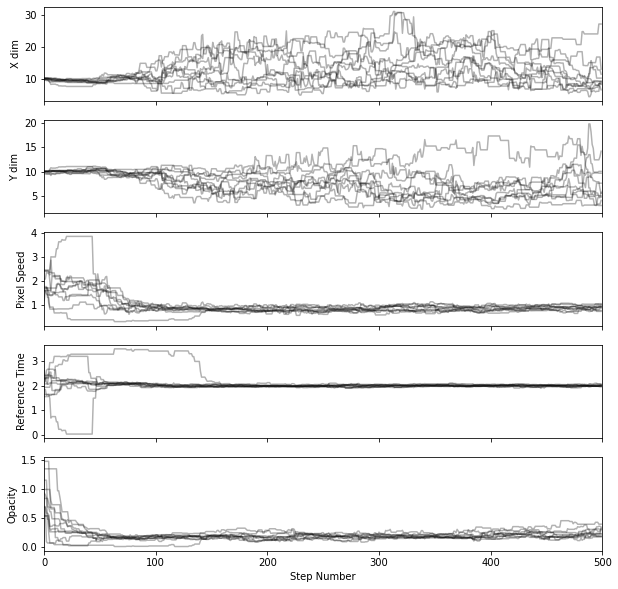

In [11]:
##This block plots the traces of the 4 parameters
fig, axes = plt.subplots(5,figsize = (10,10), sharex = True)
samples = sampler.get_chain()
labels = ["X dim", "Y dim", "Pixel Speed", "Reference Time", "Opacity"]
for i in range(ndim):
    axes[i].plot(samples[:,:,i],'k',alpha = 0.3)
    axes[i].set_xlim(0,len(samples))
    axes[i].set_ylabel(labels[i])
    
axes[-1].set_xlabel("Step Number")
plt.show()

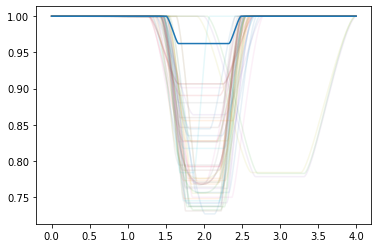

In [12]:
fig = plt.subplot()
flat_samples = sampler.get_chain(discard=10, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=50)
for ind in inds:
    sample = flat_samples[ind]
    sampleFlux = transitSim(sample[0],sample[1],20,sample[2],times,sample[3],1)
    fig.plot(times,sampleFlux,alpha = 0.1)
    
fig.plot(times,flux)
plt.show()
    